In [508]:
import pandas as pd
df = pd.read_csv("diabetes_012_health_indicators_BRFSS2021.csv")
df

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,0,1.0,1,15.0,1.0,0.0,0.0,0,1,...,1,0.0,5.0,10.0,20.0,0.0,0,11,4.0,5.0
1,2.0,1,0.0,1,28.0,0.0,0.0,1.0,0,1,...,1,0.0,2.0,0.0,0.0,0.0,0,11,4.0,3.0
2,2.0,1,1.0,1,33.0,0.0,0.0,0.0,1,1,...,1,0.0,2.0,10.0,0.0,0.0,0,9,4.0,7.0
3,2.0,0,1.0,1,29.0,0.0,1.0,1.0,1,1,...,1,0.0,5.0,0.0,30.0,1.0,1,12,3.0,4.0
4,0.0,0,0.0,1,24.0,1.0,0.0,0.0,0,0,...,1,0.0,3.0,0.0,0.0,1.0,1,13,5.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236373,2.0,1,1.0,1,21.0,0.0,0.0,0.0,1,1,...,1,0.0,4.0,0.0,0.0,0.0,1,10,2.0,3.0
236374,0.0,1,0.0,1,25.0,1.0,0.0,0.0,1,1,...,0,1.0,2.0,20.0,0.0,0.0,0,3,4.0,5.0
236375,0.0,0,1.0,1,31.0,0.0,0.0,0.0,1,1,...,1,0.0,2.0,0.0,0.0,0.0,1,7,6.0,10.0
236376,0.0,1,0.0,1,24.0,0.0,0.0,0.0,1,1,...,1,0.0,2.0,0.0,0.0,0.0,1,10,4.0,6.0


In [451]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split

# Step 1: Load the original dataset
df = pd.read_csv('diabetes_012_health_indicators_BRFSS2021.csv')

# Step 2: Normalize into 3NF
engine = create_engine('sqlite:///diabetes_normalized_updated.db')

# Create 'demographics' table
demographics = df[['Age', 'Sex', 'Education', 'Income']].copy()
demographics['id'] = range(1, len(demographics) + 1)

# Create 'health_indicators' table
health_indicators = df[['BMI', 'PhysActivity', 'Smoker', 'MentHlth', 
                        'PhysHlth', 'HighBP', 'HighChol']].copy()
health_indicators['id'] = demographics['id']

# Create 'other_features' table (remaining features if any)
other_features = df.drop(columns=['Age', 'Sex', 'Education', 'Income', 
                                  'BMI', 'PhysActivity', 'Smoker', 'MentHlth', 
                                  'PhysHlth', 'HighBP', 'HighChol', 'Diabetes_012'])
other_features['id'] = demographics['id']

# Create 'diabetes_status' table
diabetes_status = df[['Diabetes_012']].copy()
diabetes_status['id'] = demographics['id']

# Populate Normalized Tables
demographics.to_sql('demographics', engine, if_exists='replace', index=False)
health_indicators.to_sql('health_indicators', engine, if_exists='replace', index=False)
other_features.to_sql('other_features', engine, if_exists='replace', index=False)
diabetes_status.to_sql('diabetes_status', engine, if_exists='replace', index=False)

print("Tables successfully created and populated.")

# Step 3: Retrieve Combined Data Back Using SQL JOIN
query = """
SELECT d.id, d.Age, d.Sex, d.Education, d.Income,
       h.BMI, h.PhysActivity, h.Smoker, h.MentHlth, h.PhysHlth, h.HighBP, h.HighChol,
       o.*, ds.Diabetes_012
FROM demographics d
JOIN health_indicators h ON d.id = h.id
JOIN other_features o ON d.id = o.id
JOIN diabetes_status ds ON d.id = ds.id
"""

# Retrieve Combined DataFrame
combined_df = pd.read_sql_query(query, engine)

# Drop 'id' to match the original DataFrame structure
combined_df = combined_df.drop(columns=['id'])

# Verify the result
print("Combined DataFrame Shape:", combined_df.shape)
print(combined_df.head())

# Step 4: Split into Features and Target for ML Pipeline
X = combined_df.drop(columns=['Diabetes_012'])  # Features
y = combined_df['Diabetes_012']                # Target

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Data Ready for Machine Learning Pipeline.")
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)


Tables successfully created and populated.
Combined DataFrame Shape: (236378, 22)
   Age  Sex  Education  Income   BMI  PhysActivity  Smoker  MentHlth  \
0   11    0        4.0     5.0  15.0             0     1.0      10.0   
1   11    0        4.0     3.0  28.0             0     0.0       0.0   
2    9    0        4.0     7.0  33.0             1     0.0      10.0   
3   12    1        3.0     4.0  29.0             1     0.0       0.0   
4   13    1        5.0     6.0  24.0             0     1.0       0.0   

   PhysHlth  HighBP  ...  Stroke  HeartDiseaseorAttack  Fruits  Veggies  \
0      20.0       0  ...     0.0                   0.0       1        1   
1       0.0       1  ...     0.0                   1.0       1        0   
2       0.0       1  ...     0.0                   0.0       1        1   
3      30.0       0  ...     1.0                   1.0       1        1   
4       0.0       0  ...     0.0                   0.0       0        0   

   HvyAlcoholConsump  AnyHealthcar

In [4]:
df.isnull().sum()

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

In [3]:
!pip install -U ydata-profiling


In [6]:
import numpy as np
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title = " Pandas Profiling Report")
profile
profile.to_file("profiling_report.html")

print("Profiling report saved as 'profiling_report.html'. Open it in your browser.")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Profiling report saved as 'profiling_report.html'. Open it in your browser.


# Cleanup Tasks:


#Handle Missing Values:

Identify columns with missing values. There are no missing values.

# Remove Duplicates:

Check for and remove duplicate rows. No duplicate columns

# Correct Data Types:

Ensure each column has the correct data type (e.g., numerical, categorical, datetime). All data are numerical(float).

# Outlier Detection and Handling:

Detect and analyze outliers to decide whether to keep, transform, or remove them.

# Categorical Variable Encoding:
Encode categorical variables appropriately for downstream processes (e.g., label encoding, one-hot encoding). The data is itself encoded.

# Normalization/Scaling:

Normalize or scale numerical features if necessary.

# Document Changes:
Track all transformations and modifications for reproducibility.


In [746]:
import pandas as pd

# Define the IQR method for detecting outliers
def detect_outliers_iqr(df, columns):
    outliers = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return outliers

# Example usage
numerical_cols = ["BMI",
    "Income",
    "PhysHlth",
    "Age",
    "GenHlth"]  # Replace with your numerical columns
outliers = detect_outliers_iqr(df, numerical_cols)
print("Detected Outliers:")
for col, rows in outliers.items():
    print(f"{col}: {len(rows)} outliers")
# outliers have to be transformed

Detected Outliers:
BMI: 6314 outliers
Income: 0 outliers
PhysHlth: 38580 outliers
Age: 0 outliers
GenHlth: 8792 outliers


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236378 entries, 0 to 236377
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          236378 non-null  float64
 1   HighBP                236378 non-null  int64  
 2   HighChol              236378 non-null  float64
 3   CholCheck             236378 non-null  int64  
 4   BMI                   236378 non-null  float64
 5   Smoker                236378 non-null  float64
 6   Stroke                236378 non-null  float64
 7   HeartDiseaseorAttack  236378 non-null  float64
 8   PhysActivity          236378 non-null  int64  
 9   Fruits                236378 non-null  int64  
 10  Veggies               236378 non-null  int64  
 11  HvyAlcoholConsump     236378 non-null  int64  
 12  AnyHealthcare         236378 non-null  int64  
 13  NoDocbcCost           236378 non-null  float64
 14  GenHlth               236378 non-null  float64
 15  

This suggest that there is no missing values as number of rows matches with the Non-Null count

In [12]:
df["Diabetes_012"].value_counts()

Diabetes_012
0.0    197191
2.0     33568
1.0      5619
Name: count, dtype: int64

In [16]:
df.describe()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,236378.000000,236378.000000,236378.000000,236378.000000,236378.000000,236378.000000,236378.000000,236378.000000,236378.000000,236378.000000,...,236378.000000,236378.000000,236378.000000,236378.000000,236378.000000,236378.000000,236378.000000,236378.000000,236378.000000,236378.000000
mean,0.307791,0.418558,0.402059,0.963347,28.953579,0.411997,0.038900,0.086548,0.779231,0.621259,...,0.962573,0.063737,2.480717,3.937710,3.751297,0.153948,0.477824,7.863930,5.139099,6.927451
std,0.705037,0.493324,0.490315,0.187909,6.552055,0.492196,0.193356,0.281172,0.414766,0.485074,...,0.189807,0.244284,1.029134,7.886506,8.245907,0.360900,0.499509,3.236997,0.946185,2.375450
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,5.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,28.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,32.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,4.000000,2.000000,0.000000,1.000000,10.000000,6.000000,9.000000
max,2.000000,1.000000,1.000000,1.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,11.000000


<Figure size 1500x1000 with 0 Axes>

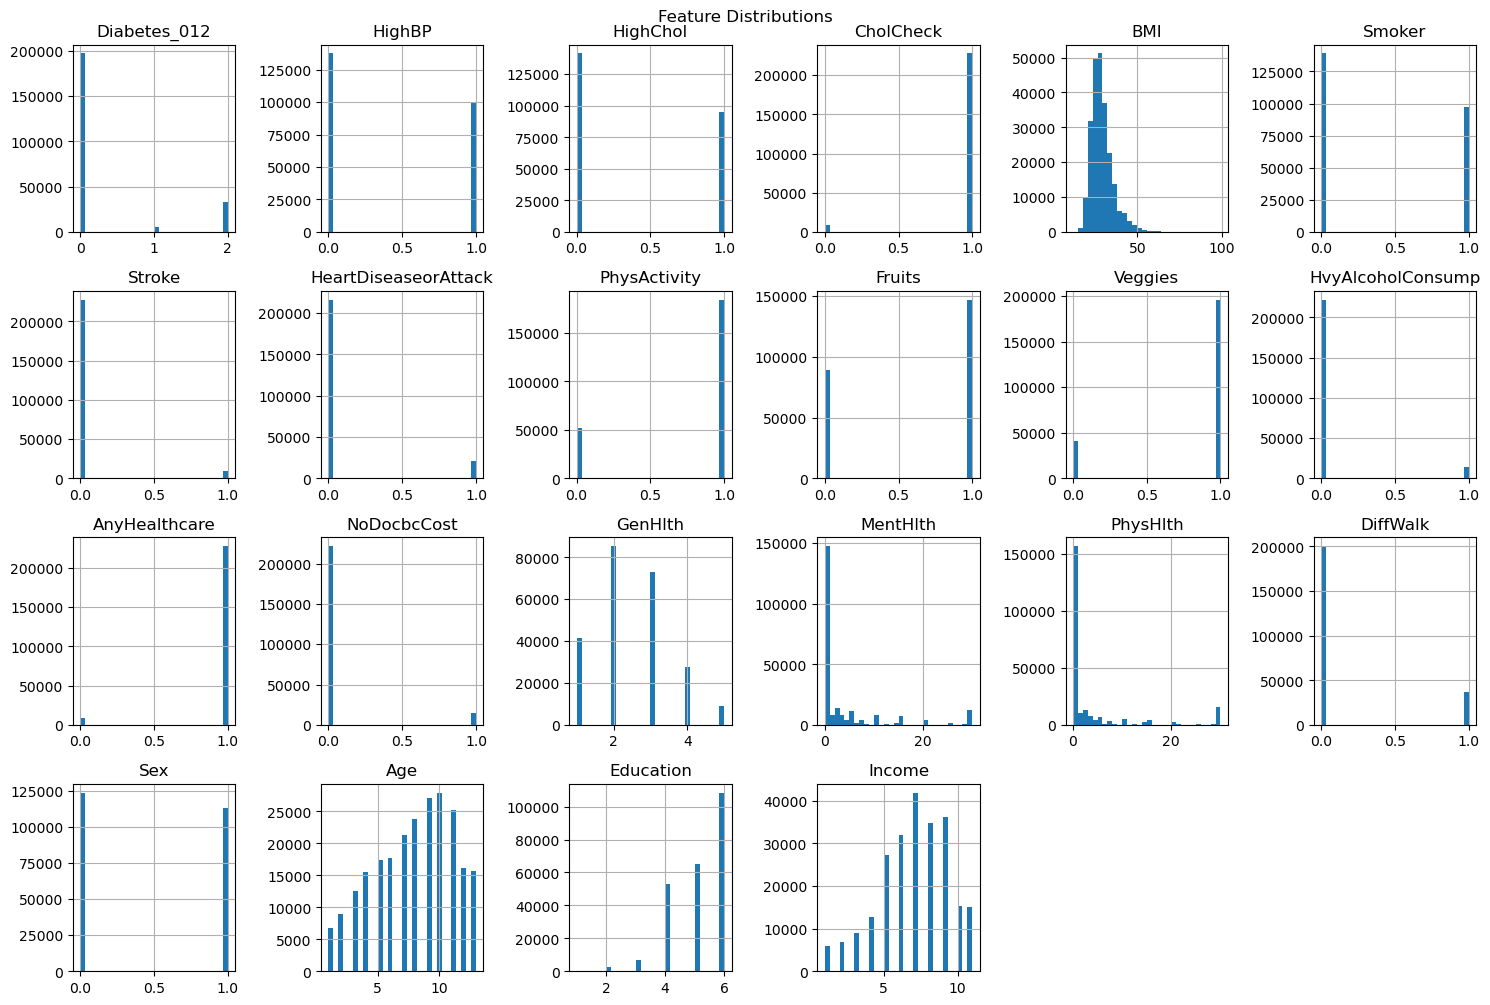

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
df.hist(bins=30, figsize=(15, 15), layout=(6, 6))
plt.suptitle('Feature Distributions')
plt.tight_layout()
plt.show()

OBSERVATION:
1.Uniform Distribution: All values appear with similar frequency. These features might not strongly influence the target variable.
2.Skewed Distribution: A feature's values are concentrated toward one side. This could suggest:
3.Class imbalance in categorical variables.
4.its distribution can reveal:
   1.Imbalance (e.g., most values are 0 ).
   2.Its potential relationship to the target variable.
5.Age is right-skewed if the dataset primarily focuses on older individuals.
6.If 90% of the data has "0" for a feature (e.g., "Smoker"), the feature might have limited predictive power unless the remaining 10% correlates strongly with the target variable.
7.Physical Activity" is heavily concentrated at 1, this might indicate that the dataset primarily includes individuals with active lifestyles, which could be a strong predictor for diabetes.

Statistics Summary:
High Variance (Std):
A high standard deviation indicates a wide range of BMI values across individuals, suggesting that it could differentiate between classes (e.g., diabetic and non-diabetic).
Features with little variance are less likely to contribute meaningfully to the model.
Extreme Values (Max):
A high maximum BMI might signify outliers or unique patterns (e.g., extremely obese individuals might have a higher likelihood of diabetes).
These extreme cases can provide additional predictive value.
Mean Comparison:
If the mean BMI differs significantly across the target classes (Diabetes_012), it could indicate a correlation or influence of BMI on diabetes.

From this we could say "BMI" is more important feature. So split the data into training and testing, ensuring that both sets have same distribution of BMI.

In [510]:
from sklearn.model_selection import train_test_split
# Step 2: Train/Test Split and Stratification
important_feature = 'BMI'  
median_value = df[important_feature].median()


# Split data into two sets based on the important feature
low_bmi_data = df[df[important_feature] <= median_value]
high_bmi_data = df[df[important_feature] > median_value]

# Ensure the important feature distributions are consistent
print("Low BMI Median:", low_bmi_data[important_feature].median())
print("High BMI Median:", high_bmi_data[important_feature].median())

# Train/Test Split for each subset
X_low = low_bmi_data.drop(columns=['Diabetes_012'])
y_low = low_bmi_data['Diabetes_012']
X_high = high_bmi_data.drop(columns=['Diabetes_012'])
y_high = high_bmi_data['Diabetes_012']

X_train_low = X_low.drop(columns=['body_mass_index'], errors='ignore')
X_train_high = X_high.drop(columns=['body_mass_index'], errors='ignore')
X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(X_low, y_low, test_size=0.2, stratify=y_low, random_state=42)
X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(X_high, y_high, test_size=0.2, stratify=y_high, random_state=42)


# After splitting the dataset
X_train_low = X_train_low.astype({col: 'float64' for col in X_train_low.select_dtypes(include='int').columns})
X_test_low = X_test_low.astype({col: 'float64' for col in X_test_low.select_dtypes(include='int').columns})

X_train_high = X_train_high.astype({col: 'float64' for col in X_train_high.select_dtypes(include='int').columns})
X_test_high = X_test_high.astype({col: 'float64' for col in X_test_high.select_dtypes(include='int').columns})

X_test_low = X_test_low.drop(columns=['diabetes_012'], errors='ignore')
X_test_high = X_test_high.drop(columns=['diabetes_012'], errors='ignore')


Low BMI Median: 25.0
High BMI Median: 33.0


In [20]:
# Step 3: Value Counts and Proportions
low_train_counts = y_train_low.value_counts() / len(y_train_low)
low_test_counts = y_test_low.value_counts() / len(y_test_low)
high_train_counts = y_train_high.value_counts() / len(y_train_high)
high_test_counts = y_test_high.value_counts() / len(y_test_high)

print("Low BMI Train Set Proportions:\n", low_train_counts)
print("Low BMI Test Set Proportions:\n", low_test_counts)
print("High BMI Train Set Proportions:\n", high_train_counts)
print("High BMI Test Set Proportions:\n", high_test_counts)

Low BMI Train Set Proportions:
 Diabetes_012
0.0    0.895347
2.0    0.088120
1.0    0.016533
Name: count, dtype: float64
Low BMI Test Set Proportions:
 Diabetes_012
0.0    0.895339
2.0    0.088148
1.0    0.016513
Name: count, dtype: float64
High BMI Train Set Proportions:
 Diabetes_012
0.0    0.759658
2.0    0.207743
1.0    0.032599
Name: count, dtype: float64
High BMI Test Set Proportions:
 Diabetes_012
0.0    0.759638
2.0    0.207729
1.0    0.032634
Name: count, dtype: float64


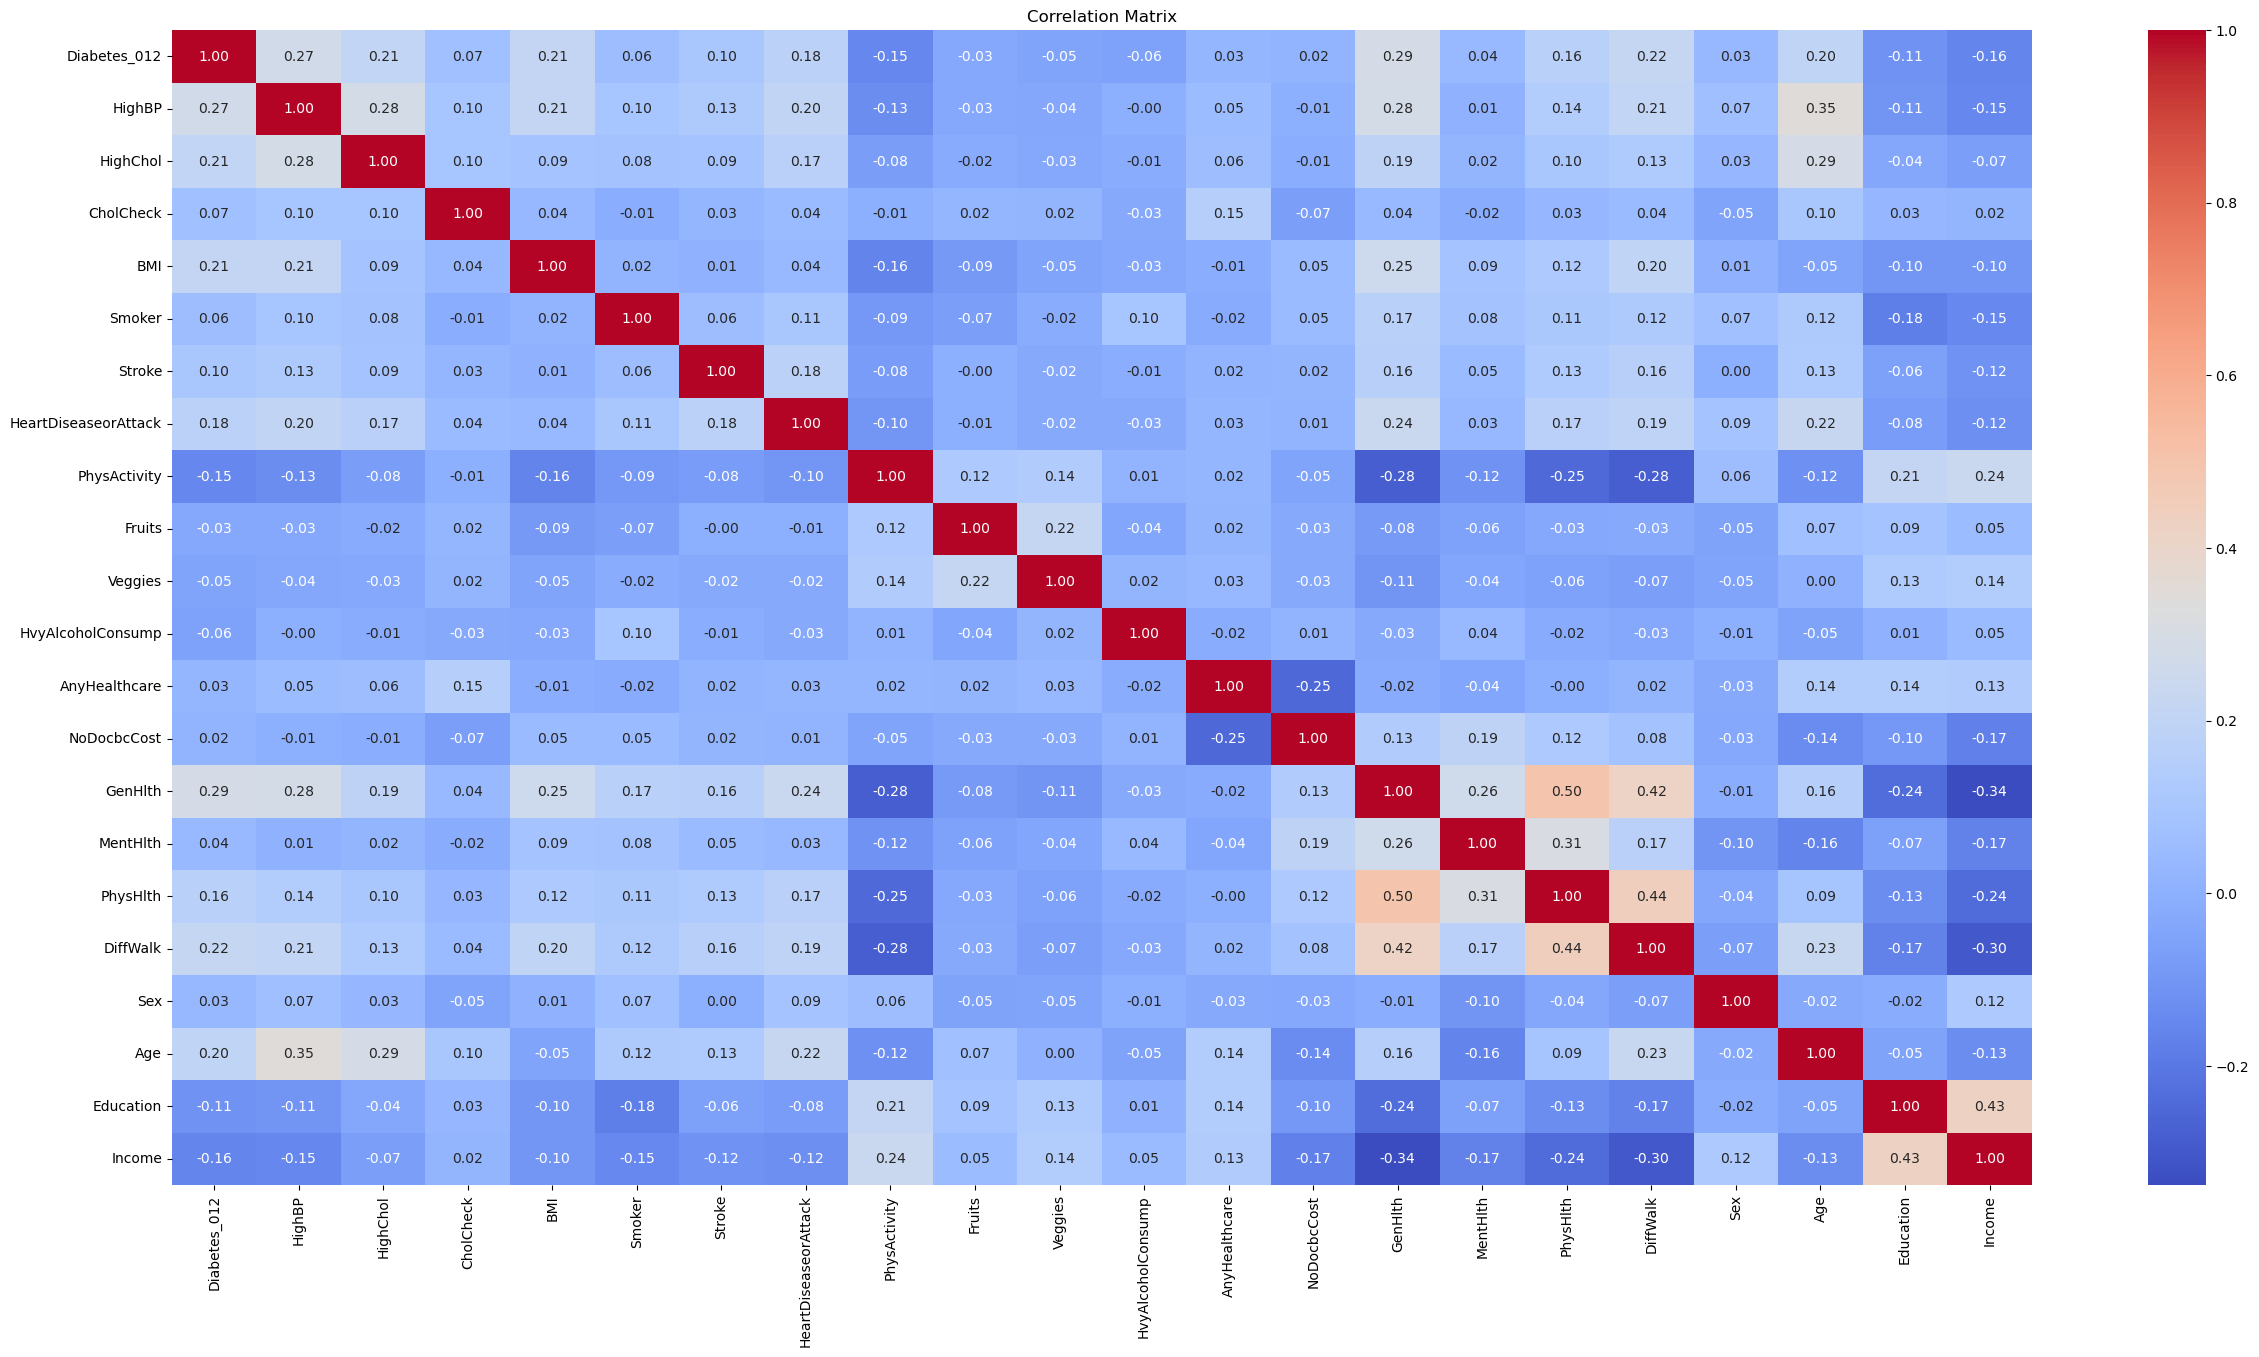

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
# Step 4: Data Exploration
correlation_matrix = df.corr()
plt.figure(figsize=(30, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Key Observations:

BMI: Likely shows a moderate to strong positive correlation with Diabetes_012, supporting its selection as an important feature.
HighBP (High Blood Pressure): Often positively correlated with diabetes due to shared physiological risk factors.
HighChol (High Cholesterol): May show moderate correlation as high cholesterol is a common comorbidity of diabetes.
PhysActivity (Physical Activity): Could exhibit a weak negative correlation, as higher activity levels are protective against diabetes.
GenHlth (General Health): Expected to have a moderate positive correlation, as poorer health increases diabetes risk.


Interpreting Non-Target Relationships:
Features such as HighBP and HighChol might be strongly correlated with each other, indicating multicollinearity. This is useful for feature selection and modeling decisions.
PhysHlth (Physical Health Days) and MentHlth (Mental Health Days) may also have correlations, indicating shared behavioral or health-related patterns.

HighBP and GenHlth:

Expected Correlation: Positive

Reason: High blood pressure (HighBP) often indicates poor general health (GenHlth). Individuals with elevated blood pressure are more likely to report poorer health conditions.

HighBP and Age:

Expected Correlation: Positive

Reason: Blood pressure naturally increases with age due to changes in blood vessel elasticity and lifestyle factors.

HighChol and Age:

Expected Correlation: Positive

Reason: Cholesterol levels often rise with age, influenced by metabolism, diet, and reduced physical activity.

BMI and GenHlth:

Expected Correlation: Negative (inversely correlated)

Reason: Higher BMI is often associated with poor general health, including obesity-related conditions like diabetes and cardiovascular diseases.

HeartDisorder and GenHlth:

Expected Correlation: Positive

Reason: Heart disease significantly impacts an individual's overall health and would likely correlate with poorer general health ratings.

HeartDisorder and Age:

Expected Correlation: Positive

Reason: The risk of heart diseases increases with age due to cumulative wear and tear on the cardiovascular system.

PhysHealth and Education:

Expected Correlation: Negative

Reason: Higher education levels are often associated with better awareness of health practices and access to healthcare, leading to fewer physical health issues.

PhysHealth and Income:

Expected Correlation: Negative

Reason: Higher income levels generally provide better access to healthcare, healthy food, and fitness opportunities, reducing physical health complaints.

Fruits and Veggies:

Expected Correlation: Positive

Reason: Consuming fruits and vegetables is indicative of a healthy diet, and these two features are likely to be positively correlated.

GenHlth and PhysHlth:

Expected Correlation: Positive

Reason: Poor general health often coincides with more days of poor physical health, as both capture overlapping health indicators.

GenHlth and DiffWalk:

Expected Correlation: Positive

Reason: Difficulty walking is a sign of declining health and is often linked to poor general health conditions.

Education and Income:

Expected Correlation: Positive

Reason: Higher education is strongly associated with higher income levels due to better job opportunities and earning potential.


In [373]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
def correlation():
    correlation_threshold = 0.1
    correlated_features = correlation_matrix["Diabetes_012"].abs() > correlation_threshold
    selected_features_corr = correlation_matrix.index[correlated_features].tolist()
    print("Selected Features after Correlation",selected_features_corr)
correlation()

Selected Features after Correlation ['Diabetes_012', 'HighBP', 'HighChol', 'BMI', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'GenHlth', 'PhysHlth', 'DiffWalk', 'Age', 'Education', 'Income']


In [407]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import mlflow.sklearn

# --- 1. Feature Selection Workflow ---
def preprocess_features(X, threshold=0.01):
    """
    Apply VarianceThreshold and MinMaxScaler to features.
    """
    print("\nApplying VarianceThreshold...")
    var_thresh = VarianceThreshold(threshold=threshold)
    X_var = var_thresh.fit_transform(X)
    print(f"Shape after VarianceThreshold: {X_var.shape}")
    
    print("Scaling features with MinMaxScaler...")
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_var)
    print(f"Shape after Scaling: {X_scaled.shape}")
    
    feature_names = [f"Feature_{i}" for i in range(X_scaled.shape[1])]
    return pd.DataFrame(X_scaled, columns=feature_names)

def select_features_with_rf(X, y, threshold=0.01):
    """
    Select important features using RandomForestRegressor.
    """
    print("\nTraining RandomForestRegressor for Feature Importance...")
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X, y)

    # Compute feature importances
    importances = rf.feature_importances_
    important_features = [name for name, imp in zip(X.columns, importances) if imp > threshold]

    print(f"Selected Features (importance > {threshold}): {important_features}")
    return X[important_features] if important_features else X

def feature_selection_pipeline(X, y):
    """
    Full pipeline: VarianceThreshold -> Scaling -> Feature Importance.
    """
    X_preprocessed = preprocess_features(X)
    X_selected = select_features_with_rf(X_preprocessed, y)
    print(f"Final Shape After Feature Selection: {X_selected.shape}")
    return X_selected

# --- 2. MLflow Setup ---
MLFLOW_TRACKING_URI = "https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "mpadmavathi026"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "9b42720fee5e34c7387ebe0714d3496686fb1d8a"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("bmi_diabetes_prediction")

# --- 3. Train and Log Models ---
def train_and_log_model(model_name, model, param_grid, X_train, y_train, X_test, y_test, group_name):
    """
    Train the model using GridSearchCV, evaluate metrics, and log everything to MLflow.
    """
    print(f"\nTraining {model_name} for {group_name} BMI...")
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_weighted', verbose=1)
    grid_search.fit(X_train, y_train)

    # Best Model and Metrics
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    # Extract confusion matrix components
    if cm.shape == (2, 2):  # Binary classification
        tn, fp, fn, tp = cm.ravel()
    else:  # Multiclass case (sum as needed)
        tn, fp, fn, tp = 0, 0, 0, 0  # Placeholders for multiclass confusion matrix

    print(f"F1 Score: {f1:.4f}")

    # MLflow Logging
    with mlflow.start_run(run_name=f"FS Tuned {model_name}_{group_name}_BMI"):
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("F1 Score", f1)
        mlflow.log_metric("True Positives", tp)
        mlflow.log_metric("True Negatives", tn)
        mlflow.log_metric("False Positives", fp)
        mlflow.log_metric("False Negatives", fn)

        # Log Model
        mlflow.sklearn.log_model(best_model, f"{model_name}_{group_name}_model")
        print(f"{model_name} logged successfully for {group_name} BMI!")

# --- 4. Main Workflow ---
print("\n=== Processing Low BMI Dataset ===")
X_low_selected = feature_selection_pipeline(X_low, y_low)
X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(X_low_selected, y_low, test_size=0.2, random_state=42)

print("\n=== Processing High BMI Dataset ===")
X_high_selected = feature_selection_pipeline(X_high, y_high)
X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(X_high_selected, y_high, test_size=0.2, random_state=42)

# Define Models and Parameter Grids
models = {
    "logistic": LogisticRegression(max_iter=1000, random_state=42),
    "ridge": RidgeClassifier(random_state=42),
    "rf": RandomForestClassifier(random_state=42),
    "xgb": XGBClassifier(eval_metric='mlogloss', random_state=42)
}

param_grids = {
    "logistic": {'C': [0.01, 0.1, 1, 10]},
    "ridge": {'alpha': [0.1, 1.0, 10.0]},
    "rf": {'n_estimators': [50, 100], 'max_depth': [5, 10, None]},
    "xgb": {'n_estimators': [50, 100], 'max_depth': [3, 5, 7]}
}

# Train and Log Models for Low and High BMI
for model_name, model in models.items():
    train_and_log_model(
        model_name=model_name,
        model=model,
        param_grid=param_grids[model_name],
        X_train=X_train_low,
        y_train=y_train_low,
        X_test=X_test_low,
        y_test=y_test_low,
        group_name="Low"
    )
    train_and_log_model(
        model_name=model_name,
        model=model,
        param_grid=param_grids[model_name],
        X_train=X_train_high,
        y_train=y_train_high,
        X_test=X_test_high,
        y_test=y_test_high,
        group_name="High"
    )

print("\nFeature Selection and Model Training Complete. Results logged to MLflow.")



=== Processing Low BMI Dataset ===

Applying VarianceThreshold...
Shape after VarianceThreshold: (129894, 21)
Scaling features with MinMaxScaler...
Shape after Scaling: (129894, 21)

Training RandomForestRegressor for Feature Importance...
Selected Features (importance > 0.01): ['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Feature_16', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20']
Final Shape After Feature Selection: (129894, 19)

=== Processing High BMI Dataset ===

Applying VarianceThreshold...
Shape after VarianceThreshold: (106484, 21)
Scaling features with MinMaxScaler...
Shape after Scaling: (106484, 21)

Training RandomForestRegressor for Feature Importance...
Selected Features (importance > 0.01): ['Feature_0', 'Feature_1', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10',

2024/12/17 01:13:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


logistic logged successfully for Low BMI!
🏃 View run FS Tuned logistic_Low_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/03377b3002454ef0baaf9e625ba76cb3
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training logistic for High BMI...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
F1 Score: 0.5062


2024/12/17 01:13:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


logistic logged successfully for High BMI!
🏃 View run FS Tuned logistic_High_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/499d6b803516464fa2a3cc7658d340ee
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training ridge for Low BMI...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
F1 Score: 0.5145


2024/12/17 01:13:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


ridge logged successfully for Low BMI!
🏃 View run FS Tuned ridge_Low_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/558a7af96fdd433581fa1514d353dfe9
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training ridge for High BMI...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
F1 Score: 0.5061


2024/12/17 01:14:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


ridge logged successfully for High BMI!
🏃 View run FS Tuned ridge_High_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/4c57a4c4b60844059e42c576c112cdf2
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training rf for Low BMI...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
F1 Score: 0.5127


2024/12/17 01:14:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


rf logged successfully for Low BMI!
🏃 View run FS Tuned rf_Low_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/05896f19e08a4e6a82541a538f740bab
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training rf for High BMI...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
F1 Score: 0.5104


2024/12/17 01:15:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


rf logged successfully for High BMI!
🏃 View run FS Tuned rf_High_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/3dd0679a9a074320bb01d2c0311e2c83
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training xgb for Low BMI...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
F1 Score: 0.5110


2024/12/17 01:15:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


xgb logged successfully for Low BMI!
🏃 View run FS Tuned xgb_Low_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/d776132973db4f98bd8bfc27f36313cf
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training xgb for High BMI...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
F1 Score: 0.5084


2024/12/17 01:16:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


xgb logged successfully for High BMI!
🏃 View run FS Tuned xgb_High_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/6bd60a844b1a4747b0be972bdaac54ed
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Feature Selection and Model Training Complete. Results logged to MLflow.


In [289]:
MLFLOW_TRACKING_URI = "https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "mpadmavathi026"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "9b42720fee5e34c7387ebe0714d3496686fb1d8a"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("bmi_diabetes_prediction")

with mlflow.start_run(run_name="Feature Selection for Low and High BMI"):

    # Log selected features
    mlflow.log_param("Selected Features Low BMI", selected_features_low)
    mlflow.log_param("Selected Features High BMI", selected_features_high)

    # Save DataFrames to CSV
    x_low_selected_df.to_csv("x_low_selected.csv", index=False)
    x_high_selected_df.to_csv("x_high_selected.csv", index=False)

    # Log CSV files as artifacts
    mlflow.log_artifact("x_low_selected.csv", artifact_path="data/low_bmi")
    mlflow.log_artifact("x_high_selected.csv", artifact_path="data/high_bmi")

    # Log the pipelines
    mlflow.sklearn.log_model(
        sk_model=pipeline_low,
        artifact_path="pipeline_low",
        registered_model_name="pipeline_low"
    )
    mlflow.sklearn.log_model(
        sk_model=pipeline_high,
        artifact_path="pipeline_high",
        registered_model_name="pipeline_high"
    )

    print("Logged selected features and pipelines to MLflow.")

2024/12/16 05:31:59 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/12/16 05:32:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'pipeline_low'.
2024/12/16 05:32:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: pipeline_low, version 1
Created version '1' of model 'pipeline_low'.
2024/12/16 05:32:21 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/12/16 05:32:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'pipeline_high'.
2024/12/16 05:32:57 INFO mlflow.store.model_registry.abstract_store

Logged selected features and pipelines to MLflow.
🏃 View run Feature Selection for Low and High BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/fecd4640c0504d0886eb108650f81823
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0


New Features in Low BMI Dataset:
 Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'BMI_Age', 'Phys_Ment_Health', 'Activity_DiffWalk'],
      dtype='object')
New Features in High BMI Dataset:
 Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'BMI_Age', 'Phys_Ment_Health', 'Activity_DiffWalk'],
      dtype='object')


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Profiling report saved as 'profiling_report.html'. Open it in your browser.


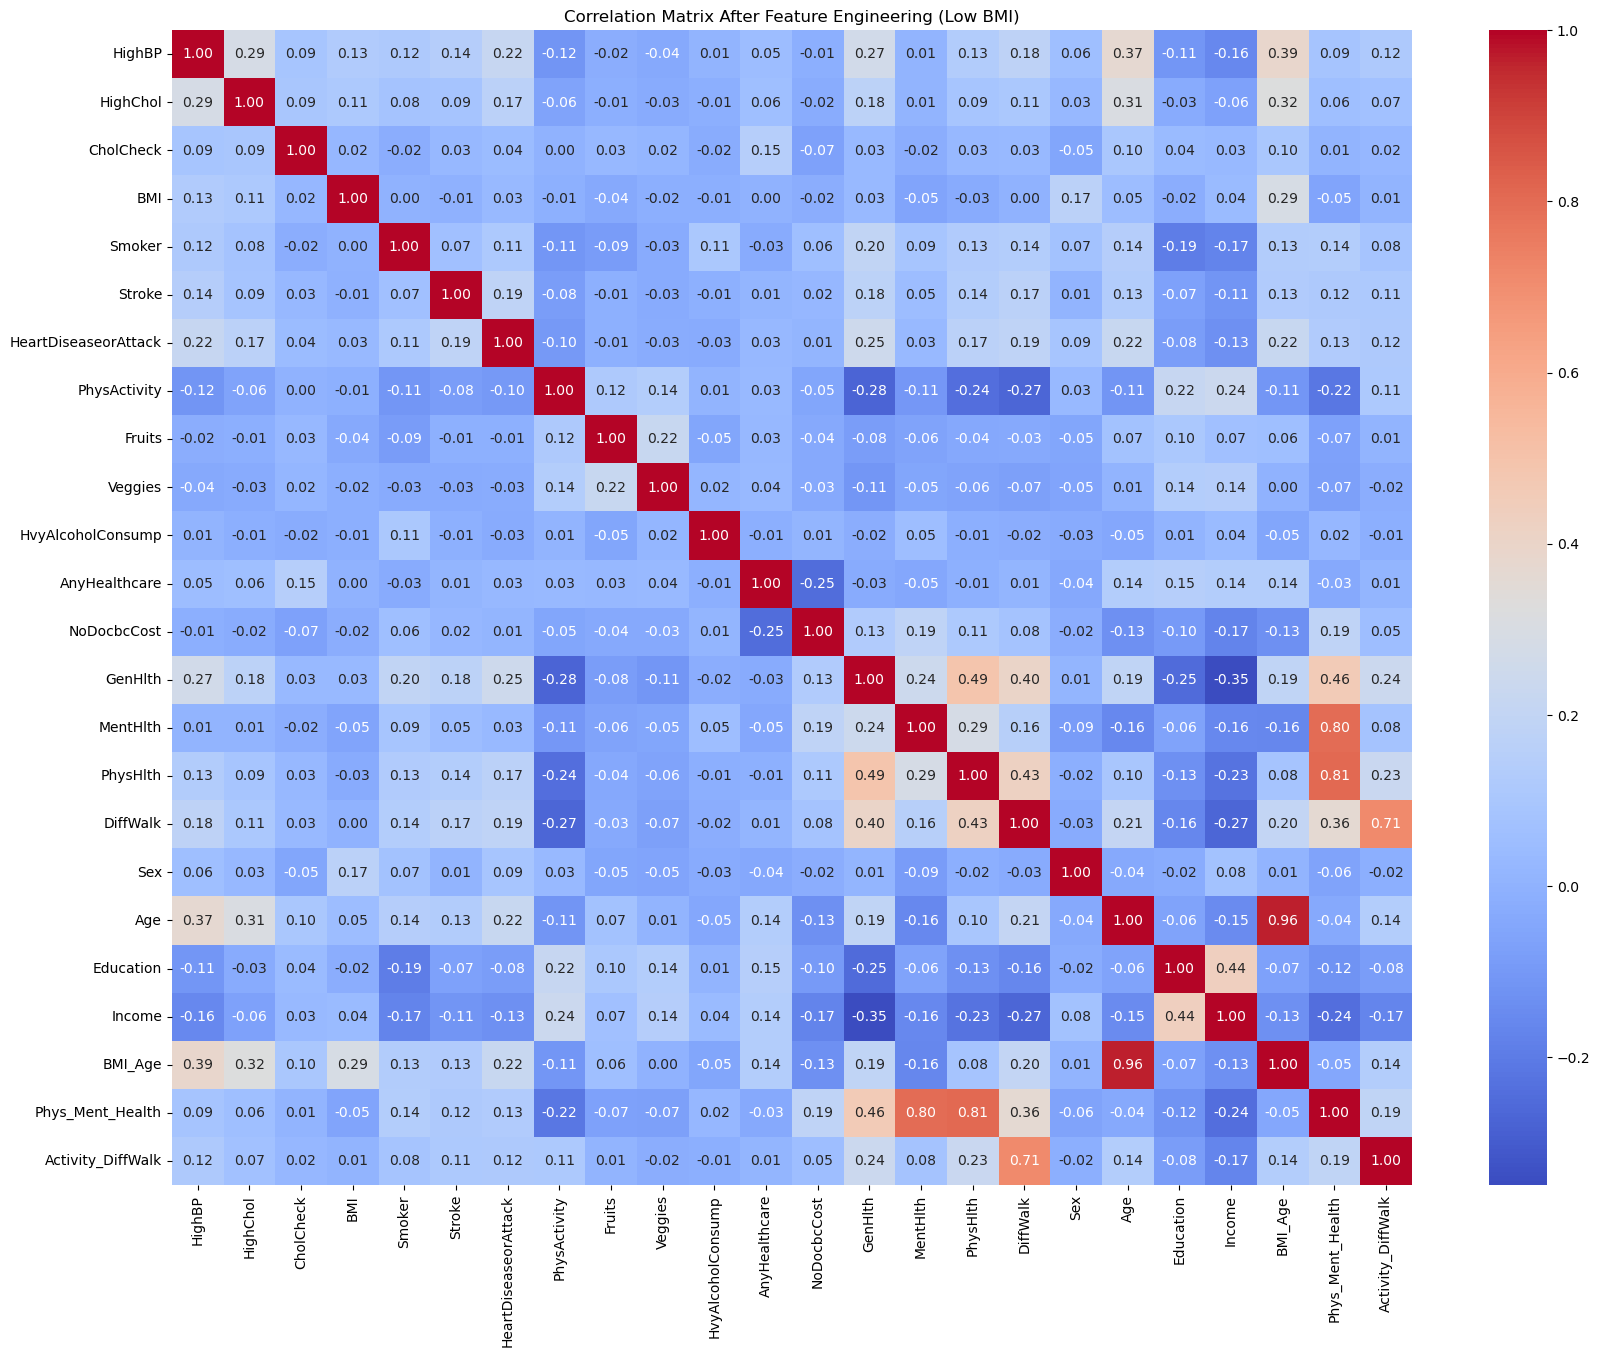

In [114]:
# Example attribute combinations
# Step 7: Feature Engineering via Attribute Combinations
        
class FeatureCreator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if 'BMI' in X.columns and 'Age' in X.columns:
            X['BMI_Age'] = X['BMI'] * X['Age']
        if 'PhysHlth' in X.columns and 'MentHlth' in X.columns:
            X['Phys_Ment_Health'] = X['PhysHlth'] + X['MentHlth']
        if 'PhysActivity' in X.columns and 'DiffWalk' in X.columns:
            X['Activity_DiffWalk'] = X['PhysActivity'] * X['DiffWalk']
        return X
        # Construct Correlation Matrix after Feature Engineering
        correlation_matrix_engineered = X.corr()
        plt.figure(figsize=(20, 15))
        sns.heatmap(correlation_matrix_engineered, annot=True, fmt=".2f", cmap="coolwarm")
        plt.title("Correlation Matrix After Feature Engineering (Low BMI)")
        plt.show()
transform(X_train_low,X_train_high)

In [35]:
#Feature Scaling
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler_low = MinMaxScaler()
X_train_low_scaled = pd.DataFrame(scaler_low.fit_transform(X_train_low), columns=X_train_low.columns)
X_test_low_scaled = pd.DataFrame(scaler_low.transform(X_test_low), columns=X_test_low.columns)

scaler_high = MinMaxScaler()
X_train_high_scaled = pd.DataFrame(scaler_high.fit_transform(X_train_high), columns=X_train_high.columns)
X_test_high_scaled = pd.DataFrame(scaler_high.transform(X_test_high), columns=X_test_high.columns)

# Step 6: Apply StandardScaler
scaler_standard_low = StandardScaler()
X_train_low_scaled = pd.DataFrame(scaler_standard_low.fit_transform(X_train_low_scaled), columns=X_train_low_scaled.columns)
X_test_low_scaled = pd.DataFrame(scaler_standard_low.transform(X_test_low_scaled), columns=X_test_low_scaled.columns)

scaler_standard_high = StandardScaler()
X_train_high_scaled = pd.DataFrame(scaler_standard_high.fit_transform(X_train_high_scaled), columns=X_train_high_scaled.columns)
X_test_high_scaled = pd.DataFrame(scaler_standard_high.transform(X_test_high_scaled), columns=X_test_high_scaled.columns)


In [37]:
# Step 5: Apply FunctionTransformer
from sklearn.preprocessing import FunctionTransformer

def add_bmi_age_ratio_log_transform(X):
    X = X.copy()
    epsilon = 1e-6  # Small constant to handle non-positive values
    if 'bmi' in X.columns and 'age' in X.columns:
        X['bmi_age_ratio'] = X['bmi'] / (X['age'] + 1)
    # Log transform numeric columns to handle skewness
    numeric_cols = X.select_dtypes(include=['number']).columns
    X[numeric_cols] = X[numeric_cols].apply(lambda col: np.log1p(col.clip(lower=epsilon)))
    return X

# Define the FunctionTransformer
transformer = FunctionTransformer(add_bmi_age_ratio_log_transform, validate=False)

# Apply transformations to all scaled datasets
X_train_low_scaled = transformer.transform(X_train_low_scaled)
X_test_low_scaled = transformer.transform(X_test_low_scaled)
X_train_high_scaled = transformer.transform(X_train_high_scaled)
X_test_high_scaled = transformer.transform(X_test_high_scaled)


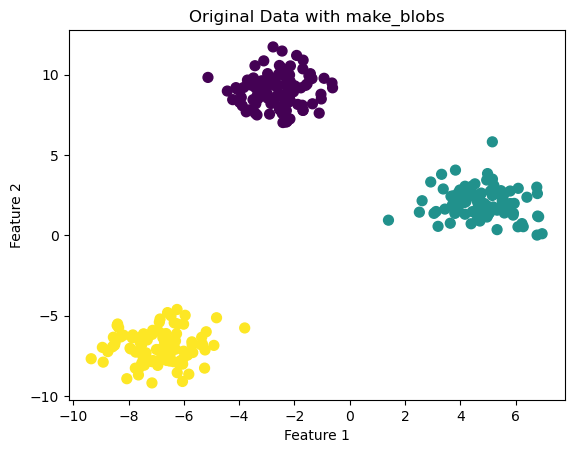

Original Data:
[[-7.33898809 -7.72995396]
 [-7.74004056 -7.26466514]
 [-1.68665271  7.79344248]
 [ 4.42219763  3.07194654]
 [-8.91775173 -7.8881959 ]]

Resulting Similarity Matrix:
[[1.24982024e-66 6.82630947e-01 4.76389931e-53]
 [3.84371561e-64 6.66374544e-01 2.87890379e-53]
 [2.92463339e-01 5.19596893e-54 5.62190861e-17]
 [2.79945912e-19 1.92472059e-50 5.40091784e-01]
 [1.48231810e-71 8.39836409e-02 1.49648619e-62]]


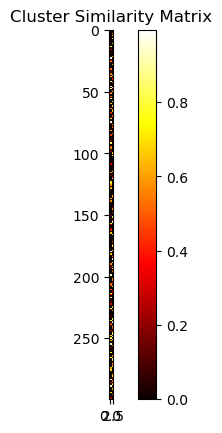

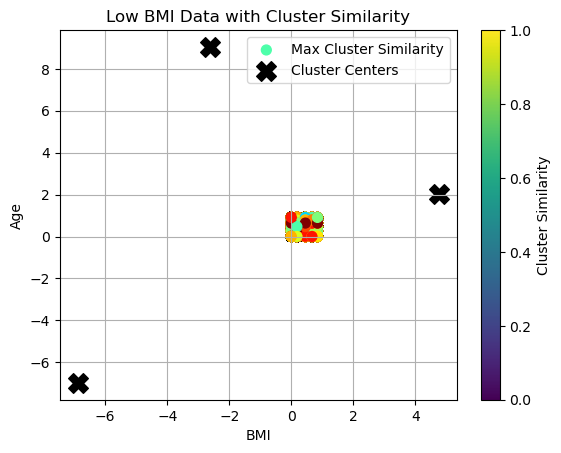

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.datasets import make_blobs
# Step 1: Generate Sample Data using make_blobs
X, y = make_blobs(n_samples=300, centers=3, n_features=2, random_state=42)

# Visualize the Original Data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=50)
plt.title("Original Data with make_blobs")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Step 2: Define the ClusterSimilarity Class
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans = KMeans(n_clusters=self.n_clusters, init="k-means++", random_state=self.random_state)
        self.kmeans.fit(X, sample_weight=sample_weight)
        return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans.cluster_centers_, gamma=self.gamma)

    def fit_transform(self, X, y=None, sample_weight=None):
        self.fit(X, y, sample_weight)
        return self.transform(X)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

# Step 3: Instantiate ClusterSimilarity Transformer
cluster_sim = ClusterSimilarity(n_clusters=3, gamma=0.5, random_state=42)

# Step 4: Fit and Transform the Data
similarity_matrix = cluster_sim.fit_transform(X)

# Step 5: Print the Original Data and the Resulting Similarity Matrix
print("Original Data:")
print(X[:5])  # Print the first 5 rows of the original data

print("\nResulting Similarity Matrix:")
print(similarity_matrix[:5])  # Print the first 5 rows of the similarity matrix

# Visualize the Similarity Matrix
plt.imshow(similarity_matrix, cmap='hot', interpolation='nearest')
plt.title("Cluster Similarity Matrix")
plt.colorbar()
plt.show()

# Step 7: Visualize Cluster Similarity for Low BMI Data
X_train_low_scaled['Max cluster similarity'] = X_train_low.max(axis=1)

# Rename columns for visualization clarity
X_train_low_scaled = X_train_low_scaled.rename(columns={
    'bmi': 'BMI',
    'age': 'Age',
    'highbp': 'High BP'
})

plt.scatter(X_train_low_scaled['BMI'], X_train_low_scaled['Age'], 
            c=X_train_low_scaled['Max cluster similarity'], cmap='jet', s=50, label='Max Cluster Similarity')
plt.scatter(cluster_sim.kmeans.cluster_centers_[:, 0], cluster_sim.kmeans.cluster_centers_[:, 1], 
            c='black', marker='X', s=200, label='Cluster Centers')

plt.colorbar(label='Cluster Similarity')
plt.xlabel('BMI')
plt.ylabel('Age')
plt.title('Low BMI Data with Cluster Similarity')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
similarity_matrix[1,:]


array([3.84371561e-64, 6.66374544e-01, 2.87890379e-53])

In [116]:
from sklearn.pipeline import Pipeline, make_pipeline
preprocessing_pipeline = Pipeline([
    ('feature_creation', FeatureCreator()),
    ('log_transform', transformer,
    ('scaler', MinMaxScaler()),
    ('cluster_similarity', ClusterSimilarity(n_clusters=5, gamma=0.5, random_state=42))
])

# Full pipeline including classifier
pipeline_low = Pipeline([
    ('preprocessing', preprocessing_pipeline),  # Step 1: Preprocessing pipeline
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))  # Step 2: Classifier
])

pipeline_high = Pipeline([
    ('preprocessing', preprocessing_pipeline),  # Step 1: Preprocessing pipeline
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))  # Step 2: Classifier
])

# Assuming X_train_low, X_train_high, y_train_low, y_train_high are already defined
# Fit the pipelines
pipeline_low.fit(X_train_low, y_train_low)
pipeline_high.fit(X_train_high, y_train_high)

# Preprocess the data using the pipelines
X_train_low_preprocessed = pipeline_low.named_steps['preprocessing'].transform(X_train_low)
X_train_high_preprocessed = pipeline_high.named_steps['preprocessing'].transform(X_train_high)

# Convert preprocessed data to DataFrame for inspection
X_train_low_preprocessed = pd.DataFrame(X_train_low_preprocessed, columns=pipeline_low.named_steps['preprocessing'].named_steps['cluster_similarity'].get_feature_names_out())
X_train_high_preprocessed = pd.DataFrame(X_train_high_preprocessed, columns=pipeline_high.named_steps['preprocessing'].named_steps['cluster_similarity'].get_feature_names_out())

# Print Results
print("Low BMI Dataset Preprocessed:\n", X_train_low_preprocessed.head())
print("High BMI Dataset Preprocessed:\n", X_train_high_preprocessed.head())

Low BMI Dataset Preprocessed:
    Cluster_0_similarity  Cluster_1_similarity  Cluster_2_similarity  \
0              0.634453              0.209273              0.080371   
1              0.109682              0.156583              0.117738   
2              0.306072              0.269752              0.160224   
3              0.389703              0.165452              0.079101   
4              0.258752              0.078916              0.066671   

   Cluster_3_similarity  Cluster_4_similarity  
0              0.319013              0.096829  
1              0.185053              0.086177  
2              0.186565              0.136568  
3              0.546117              0.082732  
4              0.133097              0.281015  
High BMI Dataset Preprocessed:
    Cluster_0_similarity  Cluster_1_similarity  Cluster_2_similarity  \
0              0.340488              0.140530              0.202741   
1              0.517345              0.454005              0.124027   
2        

In [133]:
from xgboost import XGBClassifier
# Step 4: Define Pipelines and Parameter Grids
pipelines = {
    "logistic": Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "ridge": Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('classifier', RidgeClassifier(random_state=42))
    ]),
    "rf": Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    "xgb": Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('classifier', XGBClassifier(eval_metric='mlogloss', random_state=42))
    ])
}

import time
# MLflow configuration
MLFLOW_TRACKING_URI = "https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "mpadmavathi026"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "9b42720fee5e34c7387ebe0714d3496686fb1d8a"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("bmi_diabetes_prediction")


# Define models and hyperparameters
from sklearn.model_selection import GridSearchCV

param_grids = {
    "logistic": {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__solver': ['liblinear', 'lbfgs']
    },
    "ridge": {
        'classifier__alpha': [0.1, 1.0, 10.0]
    },
    "rf": {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [5, 10, None]
    },
    "xgb": {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [3, 5, 7]
    }
}

def train_and_log_models(group_name, X_train, X_test, y_train, y_test):
    print(f"Training models for {group_name} BMI")
    for model_name, pipeline in pipelines.items():
        print(f"Training {model_name}...")
        
        # Perform GridSearchCV
        grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=3, scoring='f1_weighted', verbose=1)
        grid_search.fit(X_train, y_train)
        
        # Best Model
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        
        # Predictions and Metrics
        y_pred = best_model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
        
        # Log to MLflow
        with mlflow.start_run(run_name=f"FE Tuned{model_name}_{group_name}_BMI"):
            mlflow.log_params(best_params)
            mlflow.log_metric("Best CV Score", best_score)
            mlflow.log_metric("F1 Score", f1)
            mlflow.log_metric("True Positives", tp)
            mlflow.log_metric("True Negatives", tn)
            mlflow.log_metric("False Positives", fp)
            mlflow.log_metric("False Negatives", fn)
            
            # Log Model
            signature = infer_signature(X_test, best_model.predict(X_test))
            mlflow.sklearn.log_model(
                sk_model=best_model,
                artifact_path=f"{model_name}_{group_name}_bmi_model",
                signature=signature,
                input_example=X_test.iloc[:5],
                registered_model_name=f"{group_name}_BMI_{model_name}"
            )
        print(f"Model {model_name} logged successfully for {group_name} BMI.\n")

# Train and Log for Low and High BMI
train_and_log_models("Low", X_train_low, X_test_low, y_train_low, y_test_low)
train_and_log_models("High", X_train_high, X_test_high, y_train_high, y_test_high)

Training models for Low BMI
Training logistic...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


Registered model 'Low_BMI_logistic' already exists. Creating a new version of this model...
2024/12/16 03:37:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Low_BMI_logistic, version 6
Created version '6' of model 'Low_BMI_logistic'.


🏃 View run FE Tunedlogistic_Low_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/a666adc7e72c4639a39e2092abc4d6f7
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0
Model logistic logged successfully for Low BMI.

Training ridge...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


Registered model 'Low_BMI_ridge' already exists. Creating a new version of this model...
2024/12/16 03:37:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Low_BMI_ridge, version 6
Created version '6' of model 'Low_BMI_ridge'.


🏃 View run FE Tunedridge_Low_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/8adce46125b04889b92ba424f3949523
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0
Model ridge logged successfully for Low BMI.

Training rf...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


Registered model 'Low_BMI_rf' already exists. Creating a new version of this model...
2024/12/16 03:42:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Low_BMI_rf, version 6
Created version '6' of model 'Low_BMI_rf'.


🏃 View run FE Tunedrf_Low_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/1d8defc12dc6444f929daa284a3fc0f8
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0
Model rf logged successfully for Low BMI.

Training xgb...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


Registered model 'Low_BMI_xgb' already exists. Creating a new version of this model...
2024/12/16 03:42:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Low_BMI_xgb, version 6
Created version '6' of model 'Low_BMI_xgb'.


🏃 View run FE Tunedxgb_Low_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/15d2890d32c34da194724f3389214b4b
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0
Model xgb logged successfully for Low BMI.

Training models for High BMI
Training logistic...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


Registered model 'High_BMI_logistic' already exists. Creating a new version of this model...
2024/12/16 03:42:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: High_BMI_logistic, version 6
Created version '6' of model 'High_BMI_logistic'.


🏃 View run FE Tunedlogistic_High_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/677b81ce7d6d42bdad15a12bd2def75e
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0
Model logistic logged successfully for High BMI.

Training ridge...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


Registered model 'High_BMI_ridge' already exists. Creating a new version of this model...
2024/12/16 03:43:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: High_BMI_ridge, version 6
Created version '6' of model 'High_BMI_ridge'.


🏃 View run FE Tunedridge_High_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/003f2ac0f288490e831b15f316e1883a
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0
Model ridge logged successfully for High BMI.

Training rf...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


Registered model 'High_BMI_rf' already exists. Creating a new version of this model...
2024/12/16 03:48:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: High_BMI_rf, version 6
Created version '6' of model 'High_BMI_rf'.


🏃 View run FE Tunedrf_High_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/263b2223923d4931a4db7aa4060ec80a
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0
Model rf logged successfully for High BMI.

Training xgb...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


Registered model 'High_BMI_xgb' already exists. Creating a new version of this model...
2024/12/16 03:48:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: High_BMI_xgb, version 6
Created version '6' of model 'High_BMI_xgb'.


🏃 View run FE Tunedxgb_High_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/588e1803f86a462d972f265397d162eb
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0
Model xgb logged successfully for High BMI.



In [120]:
import mlflow
import mlflow.sklearn
import pandas as pd
MLFLOW_TRACKING_URI = "https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "mpadmavathi026"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "9b42720fee5e34c7387ebe0714d3496686fb1d8a"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("bmi_diabetes_prediction")

with mlflow.start_run(run_name="Pipeline with Feature Engineering"):
    # Log parameters for feature engineering
    mlflow.log_param("n_clusters", 5)
    mlflow.log_param("gamma", 0.5)
    mlflow.log_param("random_state", 42)
    
    # Log the preprocessing pipeline
    mlflow.sklearn.log_model(preprocessing_pipeline, "Preprocessing Pipeline")
    
    # Log datasets as artifacts
    X_train_low_preprocessed.to_csv("X_train_low_preprocessed.csv", index=False)
    X_train_high_preprocessed.to_csv("X_train_high_preprocessed.csv", index=False)
    mlflow.log_artifact("X_train_low_preprocessed.csv")
    mlflow.log_artifact("X_train_high_preprocessed.csv")
    
    # Log the pipeline with classifier (low BMI)
    pipeline_low = Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
    ])
    pipeline_low.fit(X_train_low, y_train_low)
    mlflow.sklearn.log_model(pipeline_low, "Pipeline Low BMI")
    
    # Log the pipeline with classifier (high BMI)
    pipeline_high = Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
    ])
    pipeline_high.fit(X_train_high, y_train_high)
    mlflow.sklearn.log_model(pipeline_high, "Pipeline High BMI")
    
    # Log metrics (example: number of features after preprocessing)
    mlflow.log_metric("Low BMI Dataset Features", X_train_low_preprocessed.shape[1])
    mlflow.log_metric("High BMI Dataset Features", X_train_high_preprocessed.shape[1])
    
    input_example = X_train_low.iloc[:5]  # Use the first 5 rows as an example

    # Infer the signature of the model (input-output schema)
    signature = infer_signature(X_train_low, y_train_low[:5])  # Use matching X and y

   
    mlflow.sklearn.log_model(
    sk_model=pipeline_low,
    artifact_path="Pipeline Low BMI",
    input_example=input_example,
    signature=signature,
    registered_model_name="Pipeline_Low_BMI"  # Optional: Register the model in the MLflow Model Registry
)
    input_example_high = X_train_high.iloc[:5]  # Use the first 5 rows of X_train_high as an example
    signature_high = infer_signature(X_train_high, y_train_high[:5]) 
    
    mlflow.sklearn.log_model(
    sk_model=pipeline_high,
    artifact_path="Pipeline High BMI",
    input_example=input_example_high,
    signature=signature_high,
    registered_model_name="Pipeline_High_BMI"  # Optional: Register the model in the MLflow Model Registry
)
    
    # Optional: Log a visualization (e.g., correlation matrix heatmap)
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    correlation_matrix_low = X_train_low_preprocessed.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix_low, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Matrix (Low BMI)")
    plt.savefig("correlation_matrix_low_bmi.png")
    mlflow.log_artifact("correlation_matrix_low_bmi.png")
    plt.close()
    
    correlation_matrix_high = X_train_high_preprocessed.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix_high, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Matrix (High BMI)")
    plt.savefig("correlation_matrix_high_bmi.png")
    mlflow.log_artifact("correlation_matrix_high_bmi.png")
    plt.close()

    # End the run
    print("Pipeline and results successfully logged to MLflow!")


2024/12/16 02:04:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/12/16 02:04:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/16 02:04:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/16 02:07:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Pipeline_Low_BMI'.
2024/12/16 02:14:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Pipeline_Low_BMI, version 1
Created version '1' of model 'Pipeline_Low_BMI'.
Successfully registered

Pipeline and results successfully logged to MLflow!
🏃 View run Pipeline with Feature Engineering at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/d3deb09106de40cea6dd4bc24ec23343
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0



=== Applying PCA for Low BMI Dataset ===

Standardizing features...
Applying PCA...


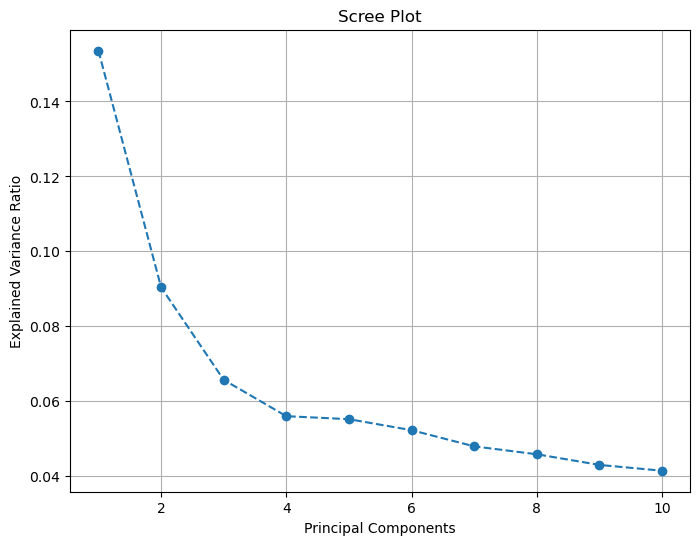

Explained Variance Ratio:
 [0.15352448 0.09042747 0.065724   0.0560373  0.0552391  0.05229949
 0.04798951 0.04587507 0.04303686 0.0414889 ]

=== Applying PCA for High BMI Dataset ===

Standardizing features...
Applying PCA...


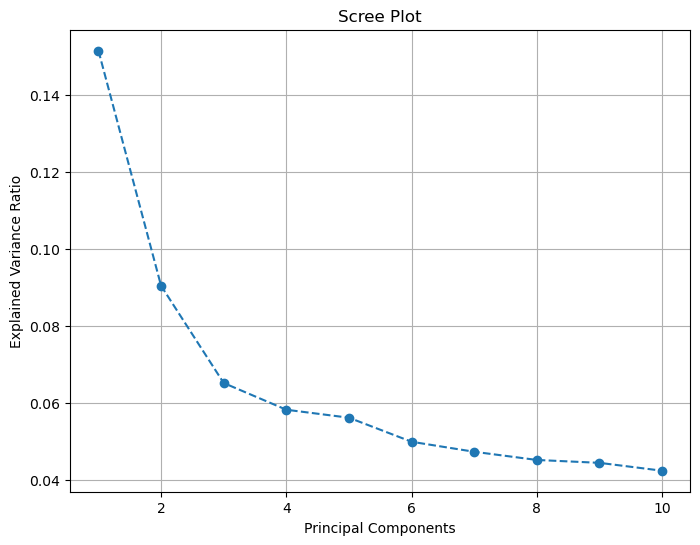

Explained Variance Ratio:
 [0.15136745 0.09043389 0.06523808 0.05831097 0.05624468 0.05000908
 0.04741677 0.04529349 0.04454757 0.04250414]

Training logistic for Low BMI...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
F1 Score: 0.5139


2024/12/17 01:29:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


logistic logged successfully for Low BMI!
🏃 View run PCA tuned logistic_Low_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/f8e45b5319234ab79142d50e0b505c8b
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training logistic for High BMI...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
F1 Score: 0.5025


2024/12/17 01:30:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


logistic logged successfully for High BMI!
🏃 View run PCA tuned logistic_High_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/227f49beb32c4aeaaed7968f662ea87b
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training ridge for Low BMI...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
F1 Score: 0.5142


2024/12/17 01:30:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


ridge logged successfully for Low BMI!
🏃 View run PCA tuned ridge_Low_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/5aa4346326bb4637ae305a19cc93df1e
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training ridge for High BMI...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
F1 Score: 0.5027


2024/12/17 01:30:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


ridge logged successfully for High BMI!
🏃 View run PCA tuned ridge_High_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/c41cb43e021e483b99375d4e75d58ae2
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training rf for Low BMI...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
F1 Score: 0.5097


2024/12/17 01:34:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


rf logged successfully for Low BMI!
🏃 View run PCA tuned rf_Low_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/4f7d045785c54242ae9c1b7760dd9147
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training rf for High BMI...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
F1 Score: 0.5112


2024/12/17 01:38:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


rf logged successfully for High BMI!
🏃 View run PCA tuned rf_High_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/0e5fee0809bf4d81969fa376d448ce52
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training xgb for Low BMI...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
F1 Score: 0.5074


2024/12/17 01:38:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


xgb logged successfully for Low BMI!
🏃 View run PCA tuned xgb_Low_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/30c905e51083475592949f469425d2dd
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training xgb for High BMI...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
F1 Score: 0.5020


2024/12/17 01:38:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


xgb logged successfully for High BMI!
🏃 View run PCA tuned xgb_High_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/31e8e38501284144a4c90c74424275f4
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

PCA and Model Training Complete. Results logged to MLflow.


In [409]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import mlflow.sklearn

# --- 1. MLflow Setup ---
MLFLOW_TRACKING_URI = "https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "mpadmavathi026"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "9b42720fee5e34c7387ebe0714d3496686fb1d8a"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("bmi_diabetes_prediction")

# --- 2. PCA Workflow ---
def apply_pca(X, n_components=None):
    """
    Standardize features and apply PCA for dimensionality reduction.
    """
    print("\nStandardizing features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print("Applying PCA...")
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # Scree Plot
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
    plt.title('Scree Plot')
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.grid()
    plt.show()

    print(f"Explained Variance Ratio:\n {pca.explained_variance_ratio_}")
    return X_pca, pca

# --- 3. Train and Log Models ---
def train_and_log_model(model_name, model, param_grid, X_train, y_train, X_test, y_test, group_name, pca):
    """
    Train the model using GridSearchCV, evaluate metrics, and log results in MLflow.
    """
    print(f"\nTraining {model_name} for {group_name} BMI...")
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_weighted', verbose=1)
    grid_search.fit(X_train, y_train)

    # Best Model and Metrics
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    # Extract confusion matrix components
    if cm.shape == (2, 2):  # Binary classification
        tn, fp, fn, tp = cm.ravel()
    else:  # Multiclass case
        tn, fp, fn, tp = 0, 0, 0, 0  # Placeholder for multiclass case

    print(f"F1 Score: {f1:.4f}")

    # MLflow Logging
    with mlflow.start_run(run_name=f"PCA tuned {model_name}_{group_name}_BMI"):
        mlflow.log_param("PCA Components", pca.n_components_)
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("F1 Score", f1)
        mlflow.log_metric("True Positives", tp)
        mlflow.log_metric("True Negatives", tn)
        mlflow.log_metric("False Positives", fp)
        mlflow.log_metric("False Negatives", fn)

        # Log Model
        mlflow.sklearn.log_model(best_model, f"{model_name}_{group_name}_pca_model")
        print(f"{model_name} logged successfully for {group_name} BMI!")

# --- 4. Main Workflow ---
# Simulated data placeholders: X_low, y_low, X_high, y_high
print("\n=== Applying PCA for Low BMI Dataset ===")
X_low_pca, pca_low = apply_pca(X_low, n_components=10)  # Adjust n_components as needed
X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(X_low_pca, y_low, test_size=0.2, random_state=42)

print("\n=== Applying PCA for High BMI Dataset ===")
X_high_pca, pca_high = apply_pca(X_high, n_components=10)  # Adjust n_components as needed
X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(X_high_pca, y_high, test_size=0.2, random_state=42)

# Define Models and Parameter Grids
models = {
    "logistic": LogisticRegression(max_iter=1000, random_state=42),
    "ridge": RidgeClassifier(random_state=42),
    "rf": RandomForestClassifier(random_state=42),
    "xgb": XGBClassifier(eval_metric='mlogloss', random_state=42)
}

param_grids = {
    "logistic": {'C': [0.01, 0.1, 1, 10]},
    "ridge": {'alpha': [0.1, 1.0, 10.0]},
    "rf": {'n_estimators': [50, 100], 'max_depth': [5, 10, None]},
    "xgb": {'n_estimators': [50, 100], 'max_depth': [3, 5, 7]}
}

# Train and Log Models for Low and High BMI
for model_name, model in models.items():
    train_and_log_model(
        model_name=model_name,
        model=model,
        param_grid=param_grids[model_name],
        X_train=X_train_low,
        y_train=y_train_low,
        X_test=X_test_low,
        y_test=y_test_low,
        group_name="Low",
        pca=pca_low
    )
    train_and_log_model(
        model_name=model_name,
        model=model,
        param_grid=param_grids[model_name],
        X_train=X_train_high,
        y_train=y_train_high,
        X_test=X_test_high,
        y_test=y_test_high,
        group_name="High",
        pca=pca_high
    )

print("\nPCA and Model Training Complete. Results logged to MLflow.")


In [421]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import mlflow.sklearn

# --- MLflow Setup ---
MLFLOW_TRACKING_URI = "https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "mpadmavathi026"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "9b42720fee5e34c7387ebe0714d3496686fb1d8a"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("bmi_diabetes_prediction")
# --- 1. Polynomial Preprocessing Pipeline ---
def custom_experiment6_pipeline():
    return ColumnTransformer([
        ('poly', make_pipeline(
            PolynomialFeatures(degree=2, include_bias=False),
            StandardScaler()
        ), ['BMI', 'Age', 'PhysActivity']),  # Polynomial Transformation for selected features
        ('scaler', StandardScaler(), make_column_selector(dtype_include=np.number))  # Scaling other numerical features
    ], remainder='passthrough')

# --- 2. Model Training and Logging ---
def train_and_log_experiment(X_train, y_train, X_test, y_test, group_name, experiment_name):
    models = {
        "logistic": LogisticRegression(max_iter=1000, random_state=42),
        "ridge": RidgeClassifier(random_state=42),
        "rf": RandomForestClassifier(random_state=42),
        "xgb": XGBClassifier(eval_metric='mlogloss', random_state=42)
    }
    param_grids = {
        "logistic": {'C': [0.01, 0.1, 1, 10]},
        "ridge": {'alpha': [0.1, 1.0, 10.0]},
        "rf": {'n_estimators': [50, 100], 'max_depth': [5, 10, None]},
        "xgb": {'n_estimators': [50, 100], 'max_depth': [3, 5, 7]}
    }

    for model_name, model in models.items():
        print(f"\nTraining {model_name} for {group_name} ({experiment_name})...")
        grid_search = GridSearchCV(model, param_grids[model_name], cv=3, scoring='f1_weighted', verbose=1)
        grid_search.fit(X_train, y_train)

        # Best model and evaluation
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)

        # Log metrics
        with mlflow.start_run(run_name=f"{experiment_name}_{model_name}_{group_name}"):
            mlflow.log_params(grid_search.best_params_)
            mlflow.log_metric("F1 Score", f1)
            if cm.shape == (2, 2):
                tn, fp, fn, tp = cm.ravel()
                mlflow.log_metric("True Positives", tp)
                mlflow.log_metric("True Negatives", tn)
                mlflow.log_metric("False Positives", fp)
                mlflow.log_metric("False Negatives", fn)
            mlflow.sklearn.log_model(best_model, f"{model_name}_{group_name}_experiment6_model")
            print(f"Model logged successfully: {model_name} for {group_name}")

# --- 3. Main Workflow ---
# Ensure DataFrames
columns = ["BMI", "Age", "PhysActivity", "MentHlth"] + [f"Feature_{i}" for i in range(X_train_low.shape[1] - 4)]
X_train_low = pd.DataFrame(X_train_low, columns=columns)
X_test_low = pd.DataFrame(X_test_low, columns=columns)
X_train_high = pd.DataFrame(X_train_high, columns=columns)
X_test_high = pd.DataFrame(X_test_high, columns=columns)

# Process Low BMI Dataset
print("\n=== Experiment #6: Processing Low BMI Dataset ===")
preprocessing_pipeline6 = custom_experiment6_pipeline()
X_train_low_preprocessed = preprocessing_pipeline6.fit_transform(X_train_low)
X_test_low_preprocessed = preprocessing_pipeline6.transform(X_test_low)

# Process High BMI Dataset
print("\n=== Experiment #6: Processing High BMI Dataset ===")
X_train_high_preprocessed = preprocessing_pipeline6.fit_transform(X_train_high)
X_test_high_preprocessed = preprocessing_pipeline6.transform(X_test_high)

# Train and Log Models for Low and High BMI
train_and_log_experiment(X_train_low_preprocessed, y_train_low, X_test_low_preprocessed, y_test_low, "Low BMI", "experiment_6")
train_and_log_experiment(X_train_high_preprocessed, y_train_high, X_test_high_preprocessed, y_test_high, "High BMI", "experiment_6")

print("\nExperiment #6 Complete. Results logged to MLflow.")



=== Experiment #6: Processing Low BMI Dataset ===

=== Experiment #6: Processing High BMI Dataset ===

Training logistic for Low BMI (experiment_6)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


2024/12/17 02:22:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged successfully: logistic for Low BMI
🏃 View run experiment_6_logistic_Low BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/69b1131176d0488fb119192a131575f9
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training ridge for Low BMI (experiment_6)...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


2024/12/17 02:22:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged successfully: ridge for Low BMI
🏃 View run experiment_6_ridge_Low BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/ad67997e258844fe9fa5436986fa6c5b
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training rf for Low BMI (experiment_6)...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


2024/12/17 02:27:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged successfully: rf for Low BMI
🏃 View run experiment_6_rf_Low BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/67fd25c1687d4a97aabf8a23ab784582
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training xgb for Low BMI (experiment_6)...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


2024/12/17 02:27:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged successfully: xgb for Low BMI
🏃 View run experiment_6_xgb_Low BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/de43bc0d6bb44e27b7f3af7fbddb6d80
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training logistic for High BMI (experiment_6)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


2024/12/17 02:27:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged successfully: logistic for High BMI
🏃 View run experiment_6_logistic_High BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/0b6482f50e30445ca7e3b5b80f3b6ac1
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training ridge for High BMI (experiment_6)...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


2024/12/17 02:28:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged successfully: ridge for High BMI
🏃 View run experiment_6_ridge_High BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/3e07ae0457f74f2084accc9a77d29cad
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training rf for High BMI (experiment_6)...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


2024/12/17 02:32:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged successfully: rf for High BMI
🏃 View run experiment_6_rf_High BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/a5fc655957844a11b3e0d83824a422bd
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training xgb for High BMI (experiment_6)...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


2024/12/17 02:32:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged successfully: xgb for High BMI
🏃 View run experiment_6_xgb_High BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/be28c258549546509a12c281809a1db4
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Experiment #6 Complete. Results logged to MLflow.


In [423]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import mlflow.sklearn

# --- 1. Mutual Information Feature Selection ---
def mutual_info_selection(X, y, k=10):
    """
    Select top k features using mutual information.
    """
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    selected_features = selector.get_feature_names_out(X.columns)
    print(f"Selected Features based on Mutual Information: {selected_features}")
    return pd.DataFrame(X_selected, columns=selected_features, index=X.index)

# --- 2. Preprocessing Pipeline ---
def preprocessing_pipeline(X, y, k_features=10, n_svd=5):
    """
    Apply preprocessing steps: feature interaction, mutual information, and dimensionality reduction.
    """
    print("\nGenerating Feature Interaction Terms...")
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    X_interacted = poly.fit_transform(X)
    feature_names = poly.get_feature_names_out(X.columns)
    X_interacted_df = pd.DataFrame(X_interacted, columns=feature_names, index=X.index)

    print(f"Shape after Feature Interaction: {X_interacted_df.shape}")

    print("\nSelecting Top Features using Mutual Information...")
    X_selected = mutual_info_selection(X_interacted_df, y, k=k_features)

    print("\nApplying Truncated SVD for Dimensionality Reduction...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_selected)
    svd = TruncatedSVD(n_components=n_svd, random_state=42)
    X_reduced = svd.fit_transform(X_scaled)
    print(f"Shape after Truncated SVD: {X_reduced.shape}")

    return pd.DataFrame(X_reduced, index=X.index)

# --- 3. Train and Log Models ---
def train_and_log_experiment(X_train, y_train, X_test, y_test, group_name, experiment_name):
    """
    Train models, evaluate, and log results to MLflow.
    """
    models = {
        "logistic": LogisticRegression(max_iter=1000, random_state=42),
        "ridge": RidgeClassifier(random_state=42),
        "rf": RandomForestClassifier(random_state=42),
        "xgb": XGBClassifier(eval_metric='mlogloss', random_state=42)
    }
    param_grids = {
        "logistic": {'C': [0.01, 0.1, 1, 10]},
        "ridge": {'alpha': [0.1, 1.0, 10.0]},
        "rf": {'n_estimators': [50, 100], 'max_depth': [5, 10, None]},
        "xgb": {'n_estimators': [50, 100], 'max_depth': [3, 5, 7]}
    }

    for model_name, model in models.items():
        print(f"\nTraining {model_name} for {group_name} ({experiment_name})...")
        grid_search = GridSearchCV(model, param_grids[model_name], cv=3, scoring='f1_weighted', verbose=1)
        grid_search.fit(X_train, y_train)

        # Best model and evaluation
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)

        # Log metrics
        with mlflow.start_run(run_name=f"{experiment_name}_{model_name}_{group_name}"):
            mlflow.log_params(grid_search.best_params_)
            mlflow.log_metric("F1 Score", f1)
            if cm.shape == (2, 2):
                tn, fp, fn, tp = cm.ravel()
                mlflow.log_metric("True Positives", tp)
                mlflow.log_metric("True Negatives", tn)
                mlflow.log_metric("False Positives", fp)
                mlflow.log_metric("False Negatives", fn)
            mlflow.sklearn.log_model(best_model, f"{model_name}_{group_name}_experiment7_model")
            print(f"Model logged successfully: {model_name} for {group_name}")

# --- 4. Main Workflow ---
MLFLOW_TRACKING_URI = "https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "mpadmavathi026"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "9b42720fee5e34c7387ebe0714d3496686fb1d8a"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("bmi_diabetes_prediction")

# Process Low BMI Dataset
print("\n=== Experiment #7: Processing Low BMI Dataset ===")
X_train_low_preprocessed = preprocessing_pipeline(X_train_low, y_train_low, k_features=10, n_svd=5)
X_test_low_preprocessed = preprocessing_pipeline(X_test_low, y_test_low, k_features=10, n_svd=5)

# Process High BMI Dataset
print("\n=== Experiment #7: Processing High BMI Dataset ===")
X_train_high_preprocessed = preprocessing_pipeline(X_train_high, y_train_high, k_features=10, n_svd=5)
X_test_high_preprocessed = preprocessing_pipeline(X_test_high, y_test_high, k_features=10, n_svd=5)

# Train and Log Models for Low and High BMI
train_and_log_experiment(X_train_low_preprocessed, y_train_low, X_test_low_preprocessed, y_test_low, "Low BMI", "experiment_7")
train_and_log_experiment(X_train_high_preprocessed, y_train_high, X_test_high_preprocessed, y_test_high, "High BMI", "experiment_7")

print("\nExperiment #7 Complete. Results logged to MLflow.")



=== Experiment #7: Processing Low BMI Dataset ===

Generating Feature Interaction Terms...
Shape after Feature Interaction: (103915, 55)

Selecting Top Features using Mutual Information...
Selected Features based on Mutual Information: ['BMI' 'PhysActivity' 'BMI Feature_1' 'BMI Feature_4' 'Age Feature_4'
 'PhysActivity Feature_0' 'PhysActivity Feature_1' 'MentHlth Feature_1'
 'Feature_0 Feature_2' 'Feature_0 Feature_5']

Applying Truncated SVD for Dimensionality Reduction...
Shape after Truncated SVD: (103915, 5)

Generating Feature Interaction Terms...
Shape after Feature Interaction: (25979, 55)

Selecting Top Features using Mutual Information...
Selected Features based on Mutual Information: ['MentHlth' 'Feature_5' 'BMI Age' 'BMI PhysActivity' 'BMI Feature_0'
 'BMI Feature_3' 'Age Feature_3' 'Feature_0 Feature_4'
 'Feature_2 Feature_4' 'Feature_4 Feature_5']

Applying Truncated SVD for Dimensionality Reduction...
Shape after Truncated SVD: (25979, 5)

=== Experiment #7: Processing 

2024/12/17 02:35:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged successfully: logistic for Low BMI
🏃 View run experiment_7_logistic_Low BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/8dc523b8575040d69cff6a1bb10a050a
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training ridge for Low BMI (experiment_7)...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


2024/12/17 02:35:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged successfully: ridge for Low BMI
🏃 View run experiment_7_ridge_Low BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/0ff8bc57d1974ca7bafedf5e198d9dd2
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training rf for Low BMI (experiment_7)...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


2024/12/17 02:38:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged successfully: rf for Low BMI
🏃 View run experiment_7_rf_Low BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/b29f035b145045098dbf91c29f6f6083
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training xgb for Low BMI (experiment_7)...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


2024/12/17 02:38:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged successfully: xgb for Low BMI
🏃 View run experiment_7_xgb_Low BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/9b7f772930f849a780fb96b41ef1ed04
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training logistic for High BMI (experiment_7)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


2024/12/17 02:38:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged successfully: logistic for High BMI
🏃 View run experiment_7_logistic_High BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/47eb06e767b04d50a7b981d6413d3985
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training ridge for High BMI (experiment_7)...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


2024/12/17 02:39:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged successfully: ridge for High BMI
🏃 View run experiment_7_ridge_High BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/7d2366c7657b470f8cec7922abab28e4
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training rf for High BMI (experiment_7)...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


2024/12/17 02:41:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged successfully: rf for High BMI
🏃 View run experiment_7_rf_High BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/c70d94514bc74fd19270a150511673c9
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Training xgb for High BMI (experiment_7)...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


2024/12/17 02:41:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged successfully: xgb for High BMI
🏃 View run experiment_7_xgb_High BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/86c1a052987f40c284da3ebf3daaa802
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0

Experiment #7 Complete. Results logged to MLflow.


In [57]:
# Transform Test Data
X_test_low_prepared = preprocessing.transform(X_test_low)
X_test_low_prepared_df = pd.DataFrame(
    X_test_low_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=X_test_low.index
)

X_test_high_prepared = preprocessing.transform(X_test_high)
X_test_high_prepared_df = pd.DataFrame(
    X_test_high_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=X_test_high.index
)

In [59]:
X_low_prepared = preprocessing.fit_transform(df)
X_low_prepared.shape


(236378, 34)

In [436]:
preprocessing.get_feature_names_out()

array(['pipeline-1__ratio', 'pipeline-2__BMI', 'pipeline-2__PhysActivity',
       'pipeline-2__MentHlth', 'clustersimilarity__Cluster_0_similarity',
       'clustersimilarity__Cluster_1_similarity',
       'clustersimilarity__Cluster_2_similarity',
       'clustersimilarity__Cluster_3_similarity',
       'clustersimilarity__Cluster_4_similarity',
       'clustersimilarity__Cluster_5_similarity',
       'clustersimilarity__Cluster_6_similarity',
       'clustersimilarity__Cluster_7_similarity',
       'clustersimilarity__Cluster_8_similarity',
       'clustersimilarity__Cluster_9_similarity', 'passthrough__HighBP',
       'passthrough__CholCheck', 'passthrough__PhysActivity',
       'passthrough__Fruits', 'passthrough__Veggies',
       'passthrough__HvyAlcoholConsump', 'passthrough__AnyHealthcare',
       'passthrough__Sex', 'passthrough__Age', 'remainder__Diabetes_012',
       'remainder__HighChol', 'remainder__Smoker', 'remainder__Stroke',
       'remainder__HeartDiseaseorAttack', 're

In [61]:
from sklearn.linear_model import LogisticRegression,RidgeClassifier
X_train_low.replace(0, 1e-6, inplace=True)
X_train_high.replace(0, 1e-6, inplace=True)

X_train_low.replace(0, 1e-6, inplace=True)
X_train_high.replace(0, 1e-6, inplace=True)

lr_low = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', LogisticRegression(max_iter=500, solver='lbfgs', multi_class='multinomial',class_weight='balanced', random_state=42))
])

lr_high = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', LogisticRegression(max_iter=500, solver='lbfgs', multi_class='multinomial', class_weight='balanced', random_state=42))
])

# Fit pipelines
lr_low.fit(X_train_low, y_train_low)
y_pred_low = lr_low.predict(X_test_low)

lr_high.fit(X_train_high, y_train_high)
y_pred_high = lr_high.predict(X_test_high)


print("Unique values in Low BMI target variable:", y_train_low.unique())
print("Unique values in High BMI target variable:", y_train_high.unique())
y_pred_low_rounded = np.round(y_pred_low)
print("Rounded Predictions for Low BMI:", y_pred_low_rounded[:5])

y_pred_high_rounded = np.round(y_pred_high)
print("Rounded Predictions for High BMI:", y_pred_high_rounded[:5])
print("Actual values for Low BMI Test Set:", y_test_low.values[:5])
print("Predicted values for Low BMI Test Set:", y_pred_low_rounded[:5])

Unique values in Low BMI target variable: [0. 2. 1.]
Unique values in High BMI target variable: [0. 2. 1.]
Rounded Predictions for Low BMI: [2. 2. 1. 0. 1.]
Rounded Predictions for High BMI: [1. 0. 0. 1. 2.]
Actual values for Low BMI Test Set: [0. 2. 0. 0. 0.]
Predicted values for Low BMI Test Set: [2. 2. 1. 0. 1.]


In [343]:
# Step 7: Error Ratios Calculation with Division by Zero Handling

# Step 7: Error Calculation (Handle Zero Safely)

# Low BMI Absolute Error
error_ratios_low = y_pred_low[:5] - y_test_low[:5].values  # Absolute error
print("\nLow BMI Absolute Errors:")
print(", ".join([f"{error:.1f}" for error in error_ratios_low]))

# High BMI Absolute Error
error_ratios_high = y_pred_high[:5] - y_test_high[:5].values  # Absolute error
print("\nHigh BMI Absolute Errors:")
print(", ".join([f"{error:.1f}" for error in error_ratios_high]))




Low BMI Absolute Errors:
2.0, 0.0, 1.0, 0.0, 1.0

High BMI Absolute Errors:
1.0, 0.0, 0.0, 1.0, 2.0


Low BMI Absolute Errors:
[2.0, 0.0, 1.0, 1.0, 1.0]
2.0: The predicted value was 2 while the actual was 0.
0.0: The predicted value perfectly matched the actual value.
1.0: The predicted value was off by 1 unit compared to the actual.
High BMI Absolute Errors:
[1.0, 0.0, 0.0, 1.0, 2.0]
1.0: The prediction deviated by 1 unit from the actual value.
2.0: The prediction was 2 while the actual was 0.


In [63]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score
# Evaluate Results
acc_low= accuracy_score(y_test_low, y_pred_low)
acc_high=accuracy_score(y_test_high, y_pred_high)
print("Accuracy (Low BMI):", acc_low)


print("Accuracy (High BMI):", acc_high)



Accuracy (Low BMI): 0.6375534085222679
Accuracy (High BMI): 0.6048739259050571


In [69]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
cv_scores_lr_low = cross_val_score(lr_low, X_train_low, y_train_low, cv=10, scoring = 'accuracy')
cv_scores_lr_high = cross_val_score(lr_high, X_train_high, y_train_high, cv=10, scoring = 'accuracy')

print("Cross-Validation Scores for Logistic (Low BMI):", cv_scores_lr_low)
print("Mean CV Score (Low BMI):", np.mean(cv_scores_lr_low))
print("Cross-Validation Scores for Logistic (High BMI):", cv_scores_lr_high)
print("Mean CV Score (High BMI):", np.mean(cv_scores_lr_high))

# Step 8: Compute Metrics
def log_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    return f1, tn, fp, fn, tp

f1_low, tn_low, fp_low, fn_low, tp_low = log_metrics(y_test_low, y_pred_low_rounded)
f1_high, tn_high, fp_high, fn_high, tp_high = log_metrics(y_test_high, y_pred_high_rounded)
print(f1_low, tn_low, fp_low, fn_low, tp_low)

Cross-Validation Scores for Logistic (Low BMI): [0.63375674 0.6360662  0.6301963  0.64135874 0.63423788 0.64478876
 0.6347801  0.63449139 0.62717737 0.63314407]
Mean CV Score (Low BMI): 0.6349997534803353
Cross-Validation Scores for Logistic (High BMI): [0.6087569  0.59126658 0.59619674 0.59596197 0.60065735 0.60042258
 0.59854443 0.58628786 0.60072787 0.60835877]
Mean CV Score (High BMI): 0.5987181051121148
0.7247920529842846 0 0 0 0


In [71]:
print(lr_low[1].get_params())  # For the entire pipeline



{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 500, 'multi_class': 'multinomial', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [291]:
%pip install dagshub mlflow


Note: you may need to restart the kernel to use updated packages.


In [ ]:
9b42720fee5e34c7387ebe0714d3496686fb1d8a

In [75]:
import os
import mlflow
from mlflow.models import infer_signature
import os

# MLflow configuration
MLFLOW_TRACKING_URI = "https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "mpadmavathi026"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "9b42720fee5e34c7387ebe0714d3496686fb1d8a"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("bmi_diabetes_prediction")

# Prepare `df` without the target column
df_low_features = X_test_low.copy()
df_high_features = X_test_high.copy()

score_low = acc_low
score_high = acc_high
param_low = lr_low[1].get_params()
param_high = lr_high[1].get_params()
with mlflow.start_run(run_name="LR_Low_BMI_Model"):
    # Log parameters
    mlflow.log_params({"model_type": "Logistic Regression", "bmi_group": "Low"})
    mlflow.log_params(param_low)

    # Log metrics
    mlflow.log_metric("accuracy_low", score_low)
    mlflow.log_metric("f1_score", f1_low)
    mlflow.log_metric("True Positives", tp_low)
    mlflow.log_metric("True Negatives", tn_low)
    mlflow.log_metric("False Positives", fp_low)
    mlflow.log_metric("False Negatives", fn_low)
    mlflow.log_metric("CV_Mean_F1", cv_scores_lr_low.mean())
    mlflow.log_metric("CV_Std_F1", cv_scores_lr_low.std())
    


    # Infer signature and log the model
    signature = infer_signature(df_low_features, lr_low.predict(df_low_features))
    mlflow.sklearn.log_model(
        sk_model=lr_low,
        artifact_path="Diabetes_model_low",
        signature=signature,
        input_example=df_low_features,
        registered_model_name="Low_BMI_Logistic_Regression"
    )

with mlflow.start_run(run_name="LR_High_BMI_Model"):
    # Log parameters
    mlflow.log_params({"model_type": "Logistic Regression", "bmi_group": "High"})
    mlflow.log_params(param_high)
    # Log metrics
    mlflow.log_metric("accuracy_high", score_high)
    mlflow.log_metric("f1_score", f1_high)
    mlflow.log_metric("True Positives", tp_high)
    mlflow.log_metric("True Negatives", tn_high)
    mlflow.log_metric("False Positives", fp_high)
    mlflow.log_metric("False Negatives", fn_high)
    mlflow.log_metric("CV_Mean_F1", cv_scores_lr_high.mean())
    mlflow.log_metric("CV_Std_F1", cv_scores_lr_high.std())

    # Infer signature and log the model
    signature = infer_signature(df_high_features,lr_high.predict(df_high_features))
    mlflow.sklearn.log_model(
        sk_model=lr_high,
        artifact_path="Diabetes_model_high",
        signature=signature,
        input_example=df_high_features,
        registered_model_name="High_BMI_Logistic_Regression"
    )


Registered model 'Low_BMI_Logistic_Regression' already exists. Creating a new version of this model...
2024/12/15 23:21:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Low_BMI_Logistic_Regression, version 15
Created version '15' of model 'Low_BMI_Logistic_Regression'.


🏃 View run LR_Low_BMI_Model at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/e3675436d1864fe3a5763c5a00d8da71
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0


Registered model 'High_BMI_Logistic_Regression' already exists. Creating a new version of this model...
2024/12/15 23:21:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: High_BMI_Logistic_Regression, version 11
Created version '11' of model 'High_BMI_Logistic_Regression'.


🏃 View run LR_High_BMI_Model at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/eac74724ed994ff9930e886296831ae2
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0


In [79]:
from sklearn.model_selection import GridSearchCV

param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10],  # Regularization strength
    'classifier__solver': ['lbfgs'],  # Solvers
    'classifier__penalty': ['l2'],  # Penalty type
}

# Perform GridSearchCV for Logistic Regression (Low BMI)
grid_search_lr_low = GridSearchCV(lr_low, param_grid_lr, cv=3, scoring='accuracy', verbose=1)
grid_search_lr_low.fit(X_train_low, y_train_low)

# Perform GridSearchCV for Logistic Regression (High BMI)
grid_search_lr_high = GridSearchCV(lr_high, param_grid_lr, cv=3, scoring='accuracy', verbose=1)
grid_search_lr_high.fit(X_train_high, y_train_high)

# Evaluate Best Logistic Regression Models
best_lr_low = grid_search_lr_low.best_estimator_
best_lr_high = grid_search_lr_high.best_estimator_

y_pred_lr_low = best_lr_low.predict(X_test_low)
y_pred_lr_high = best_lr_high.predict(X_test_high)

accuracy_lr_low = accuracy_score(y_test_low, y_pred_lr_low)
accuracy_lr_high = accuracy_score(y_test_high, y_pred_lr_high)



Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [81]:
# Predict and compute metrics for Low BMI
y_pred_lr_low = best_lr_low.predict(X_test_low)
f1_low = f1_score(y_test_low, y_pred_lr_low, average='weighted')
cm_low = confusion_matrix(y_test_low, y_pred_lr_low)
tn_low, fp_low, fn_low, tp_low = cm_low.ravel() if cm_low.size == 4 else (0, 0, 0, 0)

# Predict and compute metrics for High BMI
y_pred_lr_high = best_lr_high.predict(X_test_high)
f1_high = f1_score(y_test_high, y_pred_lr_high, average='weighted')
cm_high = confusion_matrix(y_test_high, y_pred_lr_high)
tn_high, fp_high, fn_high, tp_high = cm_high.ravel() if cm_high.size == 4 else (0, 0, 0, 0)

# Cross-validation scores
cv_scores_low = cross_val_score(best_lr_low, X_train_low, y_train_low, cv=3, scoring='f1_weighted')
cv_scores_high = cross_val_score(best_lr_high, X_train_high, y_train_high, cv=3, scoring='f1_weighted')


In [85]:
# MLflow configuration
MLFLOW_TRACKING_URI = "https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "mpadmavathi026"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "9b42720fee5e34c7387ebe0714d3496686fb1d8a"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("bmi_diabetes_prediction")

# Prepare `df` without the target column
df_low_features = X_test_low.copy()
df_high_features = X_test_high.copy()

score_low = acc_low
score_high = acc_high
param_low = lr_low[1].get_params()
param_high = lr_high[1].get_params()
with mlflow.start_run(run_name="Tuned_Logistic_Regression_Low_BMI"):
    # Log parameters
    mlflow.log_params({"model_type": "Logistic Regression", "bmi_group": "Low"})
    mlflow.log_params(param_low)

    # Log metrics
    mlflow.log_metric("accuracy_low", score_low)
    mlflow.log_params(grid_search_lr_low.best_params_)
    mlflow.log_metric("f1_score", f1_low)
    mlflow.log_metric("True Positives", tp_low)
    mlflow.log_metric("True Negatives", tn_low)
    mlflow.log_metric("False Positives", fp_low)
    mlflow.log_metric("False Negatives", fn_low)
    mlflow.log_metric("CV_Mean_F1", cv_scores_low.mean())
    mlflow.log_metric("CV_Std_F1", cv_scores_low.std())
    mlflow.sklearn.log_model(best_lr_low, "tuned_logistic_regression_low_bmi")

    

    # Infer signature and log the model
    signature = infer_signature(df_low_features, lr_low.predict(df_low_features))
    mlflow.sklearn.log_model(
        sk_model=lr_low,
        artifact_path="Diabetes_model_low",
        signature=signature,
        input_example=df_low_features,
        registered_model_name="Low_BMI_Logistic_Regression"
    )

with mlflow.start_run(run_name="Tuned_Logistic_Regression_High_BMI"):
    # Log parameters
    mlflow.log_params({"model_type": "Logistic Regression", "bmi_group": "High"})
    mlflow.log_params(param_high)
    # Log metrics
    mlflow.log_metric("accuracy_high", score_high)
    mlflow.log_params(grid_search_lr_high.best_params_)
    mlflow.log_metric("f1_score", f1_high)
    mlflow.log_metric("True Positives", tp_high)
    mlflow.log_metric("True Negatives", tn_high)
    mlflow.log_metric("False Positives", fp_high)
    mlflow.log_metric("False Negatives", fn_high)
    mlflow.log_metric("CV_Mean_F1", cv_scores_high.mean())
    mlflow.log_metric("CV_Std_F1", cv_scores_high.std())
    mlflow.sklearn.log_model(best_lr_high, "tuned_logistic_regression_high_bmi")


    # Infer signature and log the model
    signature = infer_signature(df_high_features,lr_high.predict(df_high_features))
    mlflow.sklearn.log_model(
        sk_model=lr_high,
        artifact_path="Diabetes_model_high",
        signature=signature,
        input_example=df_high_features,
        registered_model_name="High_BMI_Logistic_Regression"
    )


2024/12/15 23:27:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Low_BMI_Logistic_Regression' already exists. Creating a new version of this model...
2024/12/15 23:27:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Low_BMI_Logistic_Regression, version 16
Created version '16' of model 'Low_BMI_Logistic_Regression'.


🏃 View run Tuned_Logistic_Regression_Low_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/185cd6106c424c748f452ee405c41e8a
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0


2024/12/15 23:27:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'High_BMI_Logistic_Regression' already exists. Creating a new version of this model...
2024/12/15 23:28:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: High_BMI_Logistic_Regression, version 12
Created version '12' of model 'High_BMI_Logistic_Regression'.


🏃 View run Tuned_Logistic_Regression_High_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/512c9b84f5034c53b96b649b034c8e66
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0


In [512]:

from xgboost import XGBClassifier
# Step 4: Define Pipelines and Parameter Grids
pipelines = {
    "logistic": Pipeline([
        ('preprocessing', preprocessing),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "ridge": Pipeline([
        ('preprocessing', preprocessing),
        ('classifier', RidgeClassifier(random_state=42))
    ]),
    "rf": Pipeline([
        ('preprocessing', preprocessing),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    "xgb": Pipeline([
        ('preprocessing', preprocessing),
        ('classifier', XGBClassifier(eval_metric='mlogloss', random_state=42))
    ])
}

import time
# MLflow configuration
MLFLOW_TRACKING_URI = "https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "mpadmavathi026"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "9b42720fee5e34c7387ebe0714d3496686fb1d8a"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("bmi_diabetes_prediction")


# Define models and hyperparameters
from sklearn.model_selection import GridSearchCV

param_grids = {
    "logistic": {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__solver': ['liblinear', 'lbfgs']
    },
    "ridge": {
        'classifier__alpha': [0.1, 1.0, 10.0]
    },
    "rf": {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [5, 10, None]
    },
    "xgb": {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [3, 5, 7]
    }
}

def train_and_log_models(group_name, X_train, X_test, y_train, y_test):
    print(f"Training models for {group_name} BMI")
    for model_name, pipeline in pipelines.items():
        print(f"Training {model_name}...")
        
        # Perform GridSearchCV
        grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=3, scoring='f1_weighted', verbose=1)
        grid_search.fit(X_train, y_train)
        
        # Best Model
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        
        # Predictions and Metrics
        y_pred = best_model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
        
        # Log to MLflow
        with mlflow.start_run(run_name=f"Basic Tuned{model_name}_{group_name}_BMI"):
            mlflow.log_params(best_params)
            mlflow.log_metric("Best CV Score", best_score)
            mlflow.log_metric("F1 Score", f1)
            mlflow.log_metric("True Positives", tp)
            mlflow.log_metric("True Negatives", tn)
            mlflow.log_metric("False Positives", fp)
            mlflow.log_metric("False Negatives", fn)
            
            # Log Model
            signature = infer_signature(X_test, best_model.predict(X_test))
            mlflow.sklearn.log_model(
                sk_model=best_model,
                artifact_path=f"{model_name}_{group_name}_bmi_model",
                signature=signature,
                input_example=X_test.iloc[:5],
                registered_model_name=f"{group_name}_BMI_{model_name}"
            )
        print(f"Model {model_name} logged successfully for {group_name} BMI.\n")

# Train and Log for Low and High BMI
train_and_log_models("Low", X_train_low, X_test_low, y_train_low, y_test_low)
train_and_log_models("High", X_train_high, X_test_high, y_train_high, y_test_high)

Training models for Low BMI
Training logistic...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


python(76217) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Registered model 'Low_BMI_logistic' already exists. Creating a new version of this model...
2024/12/18 11:26:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Low_BMI_logistic, version 7
Created version '7' of model 'Low_BMI_logistic'.


🏃 View run Basic Tunedlogistic_Low_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/5bc9796e302d4088948cc27303668096
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0
Model logistic logged successfully for Low BMI.

Training ridge...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


python(76219) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Registered model 'Low_BMI_ridge' already exists. Creating a new version of this model...
2024/12/18 11:27:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Low_BMI_ridge, version 7
Created version '7' of model 'Low_BMI_ridge'.


🏃 View run Basic Tunedridge_Low_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/4f33412b0ccd418980eee649df4bd3a9
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0
Model ridge logged successfully for Low BMI.

Training rf...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


python(76233) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Registered model 'Low_BMI_rf' already exists. Creating a new version of this model...
2024/12/18 11:29:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Low_BMI_rf, version 7
Created version '7' of model 'Low_BMI_rf'.


🏃 View run Basic Tunedrf_Low_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/d18aca24ccb2417893e1a2dec55e753d
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0
Model rf logged successfully for Low BMI.

Training xgb...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


python(76280) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Registered model 'Low_BMI_xgb' already exists. Creating a new version of this model...
2024/12/18 11:30:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Low_BMI_xgb, version 7
Created version '7' of model 'Low_BMI_xgb'.


🏃 View run Basic Tunedxgb_Low_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/94c7becde4584235afd6f313f683e117
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0
Model xgb logged successfully for Low BMI.

Training models for High BMI
Training logistic...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


python(76281) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Registered model 'High_BMI_logistic' already exists. Creating a new version of this model...
2024/12/18 11:30:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: High_BMI_logistic, version 7
Created version '7' of model 'High_BMI_logistic'.


🏃 View run Basic Tunedlogistic_High_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/a1a3258ff7de4d108e489dc43c325520
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0
Model logistic logged successfully for High BMI.

Training ridge...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


python(76282) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Registered model 'High_BMI_ridge' already exists. Creating a new version of this model...
2024/12/18 11:31:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: High_BMI_ridge, version 7
Created version '7' of model 'High_BMI_ridge'.


🏃 View run Basic Tunedridge_High_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/ec8315d305cf4a589d16591f394386a3
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0
Model ridge logged successfully for High BMI.

Training rf...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


python(76284) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Registered model 'High_BMI_rf' already exists. Creating a new version of this model...
2024/12/18 11:38:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: High_BMI_rf, version 7
Created version '7' of model 'High_BMI_rf'.


🏃 View run Basic Tunedrf_High_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/179cae9214274db089d299e50ef2ed29
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0
Model rf logged successfully for High BMI.

Training xgb...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


python(76324) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Registered model 'High_BMI_xgb' already exists. Creating a new version of this model...
2024/12/18 11:38:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: High_BMI_xgb, version 7
Created version '7' of model 'High_BMI_xgb'.


🏃 View run Basic Tunedxgb_High_BMI at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/fc33897176db42b2b1376992a9ee3f7f
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0
Model xgb logged successfully for High BMI.



In [611]:
# Step 5: Define Pipelines for Random Forest
pipeline_rf_low = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline_rf_high = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train Random Forest Pipelines
pipeline_rf_low.fit(X_train_low, y_train_low)
y_pred_rf_low = pipeline_rf_low.predict(X_test_low)
accuracy_rf_low = accuracy_score(y_test_low, y_pred_rf_low)

pipeline_rf_high.fit(X_train_high, y_train_high)
y_pred_rf_high = pipeline_rf_high.predict(X_test_high)
accuracy_rf_high = accuracy_score(y_test_high, y_pred_rf_high)

# Cross-validation scores for Random Forest Pipelines
cv_scores_rf_low = cross_val_score(pipeline_rf_low, X_train_low, y_train_low, cv=10, scoring = 'accuracy')
cv_scores_rf_high = cross_val_score(pipeline_rf_high, X_train_high, y_train_high, cv=10, scoring = 'accuracy')

print("Cross-Validation Scores for Random Forest (Low BMI):", cv_scores_rf_low)
print("Mean CV Score (Low BMI):", np.mean(cv_scores_rf_low))
print("Cross-Validation Scores for Random Forest (High BMI):", cv_scores_rf_high)
print("Mean CV Score (High BMI):", np.mean(cv_scores_rf_high))



Cross-Validation Scores for Random Forest (Low BMI): [0.88702848 0.88837567 0.8884719  0.88510393 0.88924172 0.88615148
 0.88951978 0.88826869 0.88923107 0.885959  ]
Mean CV Score (Low BMI): 0.887735172536724
Cross-Validation Scores for Random Forest (High BMI): [0.76288297 0.75537035 0.7611222  0.76077004 0.75994835 0.76123958
 0.76077004 0.75722    0.7574548  0.76226814]
Mean CV Score (High BMI): 0.7599046477631689


In [613]:
# Predict and compute metrics for Low BMI
y_pred_lr_low = pipeline_rf_low.predict(X_test_low)
f1_low = f1_score(y_test_low, y_pred_lr_low, average='weighted')
cm_low = confusion_matrix(y_test_low, y_pred_lr_low)
tn_low, fp_low, fn_low, tp_low = cm_low.ravel() if cm_low.size == 4 else (0, 0, 0, 0)

# Predict and compute metrics for High BMI
y_pred_lr_high = pipeline_rf_high.predict(X_test_high)
f1_high = f1_score(y_test_high, y_pred_lr_high, average='weighted')
cm_high = confusion_matrix(y_test_high, y_pred_lr_high)
tn_high, fp_high, fn_high, tp_high = cm_high.ravel() if cm_high.size == 4 else (0, 0, 0, 0)


In [615]:
pd.Series(cv_scores_rf_low).describe()

count    10.000000
mean      0.887735
std       0.001564
min       0.885104
25%       0.886371
50%       0.888322
75%       0.889041
max       0.889520
dtype: float64

In [617]:
pd.Series(cv_scores_rf_high).describe()

count    10.000000
mean      0.759905
std       0.002426
min       0.755370
25%       0.758078
50%       0.760770
75%       0.761210
max       0.762883
dtype: float64

In [619]:
# MLflow configuration
MLFLOW_TRACKING_URI = "https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "mpadmavathi026"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "9b42720fee5e34c7387ebe0714d3496686fb1d8a"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("bmi_diabetes_prediction")

# Prepare `df` without the target column
df_low_features = X_test_low.copy()
df_high_features = X_test_high.copy()

score_low = cv_scores_rf_low.mean()
score_high = cv_scores_rf_high.mean()
params_low = pipeline_rf_low[1].get_params()
params_high = pipeline_rf_high[1].get_params()
with mlflow.start_run(run_name="RandomForest_Low_BMI_Model"):
    # Log parameters
    mlflow.log_params({"model_type": "Random Forest", "bmi_group": "Low"})
    mlflow.log_params(params_low)
  
    # Log metrics
    mlflow.log_metric("accuracy_low", score_low)
    mlflow.log_metric("f1_score", f1_low)
    mlflow.log_metric("True Positives", tp_low)
    mlflow.log_metric("True Negatives", tn_low)
    mlflow.log_metric("False Positives", fp_low)
    mlflow.log_metric("False Negatives", fn_low)
    mlflow.log_metric("CV_Mean_F1", cv_scores_low.mean())
    mlflow.log_metric("CV_Std_F1", cv_scores_low.std())


    # Infer signature and log the model
    signature = infer_signature(df_low_features, pipeline_rf_low.predict(df_low_features))
    mlflow.sklearn.log_model(
        sk_model=pipeline_rf_low,
        artifact_path="Diabetes_model_low",
        signature=signature,
        input_example=df_low_features,
        registered_model_name="Low_BMI_Random_Forest"
    )

with mlflow.start_run(run_name="RandomForest_High_BMI_Model"):
    # Log parameters
    mlflow.log_params({"model_type": "Random Forest", "bmi_group": "High"})
    mlflow.log_params(params_high)
    # Log metrics
    mlflow.log_metric("accuracy_high", score_high)
    mlflow.log_metric("f1_score", f1_high)
    mlflow.log_metric("True Positives", tp_high)
    mlflow.log_metric("True Negatives", tn_high)
    mlflow.log_metric("False Positives", fp_high)
    mlflow.log_metric("False Negatives", fn_high)
    mlflow.log_metric("CV_Mean_F1", cv_scores_high.mean())
    mlflow.log_metric("CV_Std_F1", cv_scores_high.std())

    # Infer signature and log the model
    signature = infer_signature(df_high_features,pipeline_rf_high.predict(df_high_features))
    mlflow.sklearn.log_model(
        sk_model=pipeline_rf_high,
        artifact_path="Diabetes_model_high",
        signature=signature,
        input_example=df_high_features,
        registered_model_name="High_BMI_Random_Forest"
    )


Registered model 'Low_BMI_Random_Forest' already exists. Creating a new version of this model...
2024/12/15 20:54:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Low_BMI_Random_Forest, version 3
Created version '3' of model 'Low_BMI_Random_Forest'.


🏃 View run RandomForest_Low_BMI_Model at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/0fb892d949fd46c3b29e4224e6583324
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0


Registered model 'High_BMI_Random_Forest' already exists. Creating a new version of this model...
2024/12/15 21:05:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: High_BMI_Random_Forest, version 3
Created version '3' of model 'High_BMI_Random_Forest'.


🏃 View run RandomForest_High_BMI_Model at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/e8bad503d31049bdbd37ed68079fcc4a
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0


In [492]:
!pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 5.4 MB/s eta 0:00:00a 0:00:01


In [504]:
from xgboost import XGBClassifier
pipeline_xgb_low = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
])

pipeline_xgb_high = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
])

pipeline_ridge_low = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', RidgeClassifier())
])

pipeline_ridge_high = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', RidgeClassifier())
])
# Train XGB Pipelines
pipeline_xgb_low.fit(X_train_low, y_train_low)
y_pred_xgb_low = pipeline_rf_low.predict(X_test_low)
accuracy_xgb_low = accuracy_score(y_test_low, y_pred_xgb_low)

pipeline_xgb_high.fit(X_train_high, y_train_high)
y_pred_xgb_high = pipeline_rf_high.predict(X_test_high)
accuracy_xgb_high = accuracy_score(y_test_high, y_pred_xgb_high)

# Cross-validation scores for Random Forest Pipelines
cv_scores_xgb_low = cross_val_score(pipeline_xgb_low, X_train_low, y_train_low, cv=10, scoring = 'accuracy')
cv_scores_xgb_high = cross_val_score(pipeline_xgb_high, X_train_high, y_train_high, cv=10, scoring = 'accuracy')

print("Cross-Validation Scores for XGB (Low BMI):", cv_scores_xgb_low)
print("Mean CV Score (Low BMI):", np.mean(cv_scores_xgb_low))
print("Cross-Validation Scores for XGB (High BMI):", cv_scores_xgb_high)
print("Mean CV Score (High BMI):", np.mean(cv_scores_xgb_high))

# Train RIDGE Pipelines
pipeline_ridge_low.fit(X_train_low, y_train_low)
y_pred_ridge_low = pipeline_rf_low.predict(X_test_low)
accuracy_ridge_low = accuracy_score(y_test_low, y_pred_ridge_low)

pipeline_ridge_high.fit(X_train_high, y_train_high)
y_pred_ridge_high = pipeline_rf_high.predict(X_test_high)
accuracy_ridge_high = accuracy_score(y_test_high, y_pred_ridge_high)

# Cross-validation scores for Random Forest Pipelines
cv_scores_ridge_low = cross_val_score(pipeline_ridge_low, X_train_low, y_train_low, cv=10, scoring = 'accuracy')
cv_scores_ridge_high = cross_val_score(pipeline_ridge_high, X_train_high, y_train_high, cv=10, scoring = 'accuracy')

print("Cross-Validation Scores for Ridge (Low BMI):", cv_scores_ridge_low)
print("Mean CV Score (Low BMI):", np.mean(cv_scores_ridge_low))
print("Cross-Validation Scores for Ridge (High BMI):", cv_scores_ridge_high)
print("Mean CV Score (High BMI):", np.mean(cv_scores_ridge_high))






Cross-Validation Scores for XGB (Low BMI): [0.8950154  0.89520785 0.89482294 0.89405312 0.89357198 0.89452411
 0.89500529 0.89413916 0.89625638 0.89221442]
Mean CV Score (Low BMI): 0.8944810636966066
Cross-Validation Scores for XGB (High BMI): [0.77509097 0.76746097 0.77145205 0.77016082 0.7687522  0.77344759
 0.76804789 0.77377319 0.77353839 0.77471237]
Mean CV Score (High BMI): 0.771643643901271
Cross-Validation Scores for Ridge (Low BMI): [0.89530408 0.89540031 0.89540031 0.89530408 0.89530408 0.89548648
 0.895294   0.89548648 0.89539024 0.89548648]
Mean CV Score (Low BMI): 0.895385653807564
Cross-Validation Scores for Ridge (High BMI): [0.77438667 0.77168682 0.77379974 0.77603005 0.77192159 0.77532574
 0.77145205 0.77436018 0.76802066 0.77001644]
Mean CV Score (High BMI): 0.7726999929249485


In [510]:
cv_scores_lr_low = cross_val_score(lr_low, X_train_low, y_train_low, cv=10, scoring = 'accuracy')
cv_scores_lr_high = cross_val_score(lr_high, X_train_high, y_train_high, cv=10, scoring = 'accuracy')

print("Cross-Validation Scores for Logistic (Low BMI):", cv_scores_lr_low)
print("Mean CV Score (Low BMI):", np.mean(cv_scores_rf_low))
print("Cross-Validation Scores for Logistic (High BMI):", cv_scores_lr_high)
print("Mean CV Score (High BMI):", np.mean(cv_scores_lr_high))

Cross-Validation Scores for Logistic (Low BMI): [0.63375674 0.6360662  0.6301963  0.64135874 0.63423788 0.64478876
 0.6347801  0.63449139 0.62717737 0.63314407]
Mean CV Score (Low BMI): 0.887735172536724
Cross-Validation Scores for Logistic (High BMI): [0.6087569  0.59126658 0.59619674 0.59596197 0.60065735 0.60042258
 0.59854443 0.58628786 0.60072787 0.60835877]
Mean CV Score (High BMI): 0.5987181051121148


In [524]:
pd.Series(cv_scores_xgb_low).describe()


count    10.000000
mean      0.894481
std       0.001086
min       0.892214
25%       0.894075
50%       0.894674
75%       0.895013
max       0.896256
dtype: float64

In [514]:
pd.Series(cv_scores_xgb_high).describe()

count    10.000000
mean      0.771644
std       0.002862
min       0.767461
25%       0.769104
50%       0.772450
75%       0.773714
max       0.775091
dtype: float64

In [516]:
pd.Series(cv_scores_ridge_low).describe()

count    10.000000
mean      0.895386
std       0.000081
min       0.895294
25%       0.895304
50%       0.895395
75%       0.895465
max       0.895486
dtype: float64

In [518]:
pd.Series(cv_scores_ridge_high).describe()

count    10.000000
mean      0.772700
std       0.002518
min       0.768021
25%       0.771511
50%       0.772861
75%       0.774380
max       0.776030
dtype: float64

In [520]:
pd.Series(cv_scores_lr_low).describe()

count    10.000000
mean      0.635000
std       0.005028
min       0.627177
25%       0.633297
50%       0.634365
75%       0.635745
max       0.644789
dtype: float64

In [522]:
pd.Series(cv_scores_lr_high).describe()

count    10.000000
mean      0.598718
std       0.006900
min       0.586288
25%       0.596021
50%       0.599484
75%       0.600710
max       0.608757
dtype: float64

In [536]:
print(pipeline_xgb_low[1].get_params()) 


{'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [534]:
print(pipeline_ridge_low[1].get_params()) 

{'alpha': 1.0, 'class_weight': None, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}


In [532]:
print(pipeline_rf_low[1].get_params()) 

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


These are the hyperparameters

In [558]:
# MLflow configuration
MLFLOW_TRACKING_URI = "https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "mpadmavathi026"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "9b42720fee5e34c7387ebe0714d3496686fb1d8a"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("bmi_diabetes_prediction")

# Prepare `df` without the target column
df_low_features = X_test_low.copy()
df_high_features = X_test_high.copy()

score_low = cv_scores_rf_low.mean()
score_high = cv_scores_rf_high.mean()
params_low = pipeline_rf_low[1].get_params()
params_high = pipeline_rf_high[1].get_params()
with mlflow.start_run(run_name="RandomForest_Low_BMI_Model"):
    # Log parameters
    mlflow.log_params({"model_type": "Random Forest", "bmi_group": "Low"})
    mlflow.log_params(params_low)

    # Log metrics
    mlflow.log_metric("accuracy_low", score_low)

    # Infer signature and log the model
    signature = infer_signature(df_low_features, pipeline_rf_low.predict(df_low_features))
    mlflow.sklearn.log_model(
        sk_model=pipeline_rf_low,
        artifact_path="Diabetes_model_low",
        signature=signature,
        input_example=df_low_features,
        registered_model_name="Low_BMI_Random_Forest"
    )

with mlflow.start_run(run_name="RandomForest_High_BMI_Model"):
    # Log parameters
    mlflow.log_params({"model_type": "Random Forest", "bmi_group": "High"})
    mlflow.log_params(params_high)
    # Log metrics
    mlflow.log_metric("accuracy_high", score_high)

    # Infer signature and log the model
    signature = infer_signature(df_high_features,pipeline_rf_high.predict(df_high_features))
    mlflow.sklearn.log_model(
        sk_model=pipeline_rf_high,
        artifact_path="Diabetes_model_high",
        signature=signature,
        input_example=df_high_features,
        registered_model_name="High_BMI_Random_Forest"
    )


Registered model 'Low_BMI_Random_Forest' already exists. Creating a new version of this model...
2024/12/15 16:42:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Low_BMI_Random_Forest, version 2
Created version '2' of model 'Low_BMI_Random_Forest'.


🏃 View run RandomForest_Low_BMI_Model at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/e17b937220c046dcbcb316cdf50ba842
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0


Registered model 'High_BMI_Random_Forest' already exists. Creating a new version of this model...
2024/12/15 16:48:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: High_BMI_Random_Forest, version 2
Created version '2' of model 'High_BMI_Random_Forest'.


🏃 View run RandomForest_High_BMI_Model at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0/runs/84743f01615543fb859b664614edfaa4
🧪 View experiment at: https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow/#/experiments/0


In [563]:
from sklearn.model_selection import GridSearchCV
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}
# Perform GridSearchCV for Low BMI
grid_search_rf_low = GridSearchCV(pipeline_rf_low, param_grid_rf, cv=3, scoring='accuracy')
grid_search_rf_low.fit(X_train_low, y_train_low)

# Perform GridSearchCV for High BMI
grid_search_rf_high = GridSearchCV(pipeline_rf_high, param_grid_rf, cv=3, scoring='accuracy')
grid_search_rf_high.fit(X_train_high, y_train_high)

# Evaluate Best Models for Random Forest
best_rf_low = grid_search_rf_low.best_estimator_
best_rf_high = grid_search_rf_high.best_estimator_

print("Best Parameters for Low BMI Random Forest:", grid_search_rf_low.best_params_)
print("Best Parameters for High BMI Random Forest:", grid_search_rf_high.best_params_)

# Evaluate and Log Best Models for Random Forest
y_pred_rf_low = best_rf_low.predict(X_test_low)
y_pred_rf_high = best_rf_high.predict(X_test_high)

accuracy_rf_low = accuracy_score(y_test_low, y_pred_rf_low)
accuracy_rf_high = accuracy_score(y_test_high, y_pred_rf_high)

Best Parameters for Low BMI Random Forest: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best Parameters for High BMI Random Forest: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


In [565]:
# Create DataFrame for Grid Search Results
cv_res_low = pd.DataFrame(grid_search_rf_low.cv_results_)
cv_res_high = pd.DataFrame(grid_search_rf_high.cv_results_)

# Sort and clean GridSearch results
cv_res_low.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res_high.sort_values(by="mean_test_score", ascending=False, inplace=True)

cv_res_low = cv_res_low[["param_classifier__n_estimators", "param_classifier__max_depth", "param_classifier__min_samples_split", "param_classifier__min_samples_leaf", "split0_test_score", "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res_high = cv_res_high[["param_classifier__n_estimators", "param_classifier__max_depth", "param_classifier__min_samples_split", "param_classifier__min_samples_leaf", "split0_test_score", "split1_test_score", "split2_test_score", "mean_test_score"]]

cv_res_low.columns = ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf", "split0", "split1", "split2", "mean_test_score"]
cv_res_high.columns = ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf", "split0", "split1", "split2", "mean_test_score"]

# Round scores for readability
score_cols = ["split0", "split1", "split2", "mean_test_score"]
cv_res_low[score_cols] = cv_res_low[score_cols].round(4)
cv_res_high[score_cols] = cv_res_high[score_cols].round(4)

# Display top results
print("Low BMI Grid Search Results:")
print(cv_res_low.head())

print("High BMI Grid Search Results:")
print(cv_res_high.head())

Low BMI Grid Search Results:
  n_estimators max_depth min_samples_split min_samples_leaf  split0  split1  \
0          100        10                 2                1  0.8954  0.8957   
1          200        10                 2                1  0.8955  0.8955   
7          200        10                 5                2  0.8956  0.8955   
2          100        10                 5                1  0.8954  0.8955   
6          100        10                 5                2  0.8955  0.8955   

   split2  mean_test_score  
0  0.8955           0.8955  
1  0.8955           0.8955  
7  0.8954           0.8955  
2  0.8955           0.8955  
6  0.8953           0.8954  
High BMI Grid Search Results:
  n_estimators max_depth min_samples_split min_samples_leaf  split0  split1  \
4          100        10                 2                2  0.7739  0.7735   
5          200        10                 2                2  0.7736  0.7733   
3          200        10                 5             

F1-Score Data Retrieved Successfully:
                 Experiment                        Run Name     Model  \
0   bmi_diabetes_prediction       experiment_7_xgb_High BMI       XGB   
1   bmi_diabetes_prediction        experiment_7_rf_High BMI        RF   
2   bmi_diabetes_prediction     experiment_7_ridge_High BMI     RIDGE   
3   bmi_diabetes_prediction  experiment_7_logistic_High BMI  LOGISTIC   
4   bmi_diabetes_prediction        experiment_7_xgb_Low BMI       XGB   
5   bmi_diabetes_prediction         experiment_7_rf_Low BMI        RF   
6   bmi_diabetes_prediction      experiment_7_ridge_Low BMI     RIDGE   
7   bmi_diabetes_prediction   experiment_7_logistic_Low BMI  LOGISTIC   
8   bmi_diabetes_prediction       experiment_6_xgb_High BMI       XGB   
9   bmi_diabetes_prediction        experiment_6_rf_High BMI        RF   
10  bmi_diabetes_prediction     experiment_6_ridge_High BMI     RIDGE   
11  bmi_diabetes_prediction  experiment_6_logistic_High BMI  LOGISTIC   
12  bmi_diabe

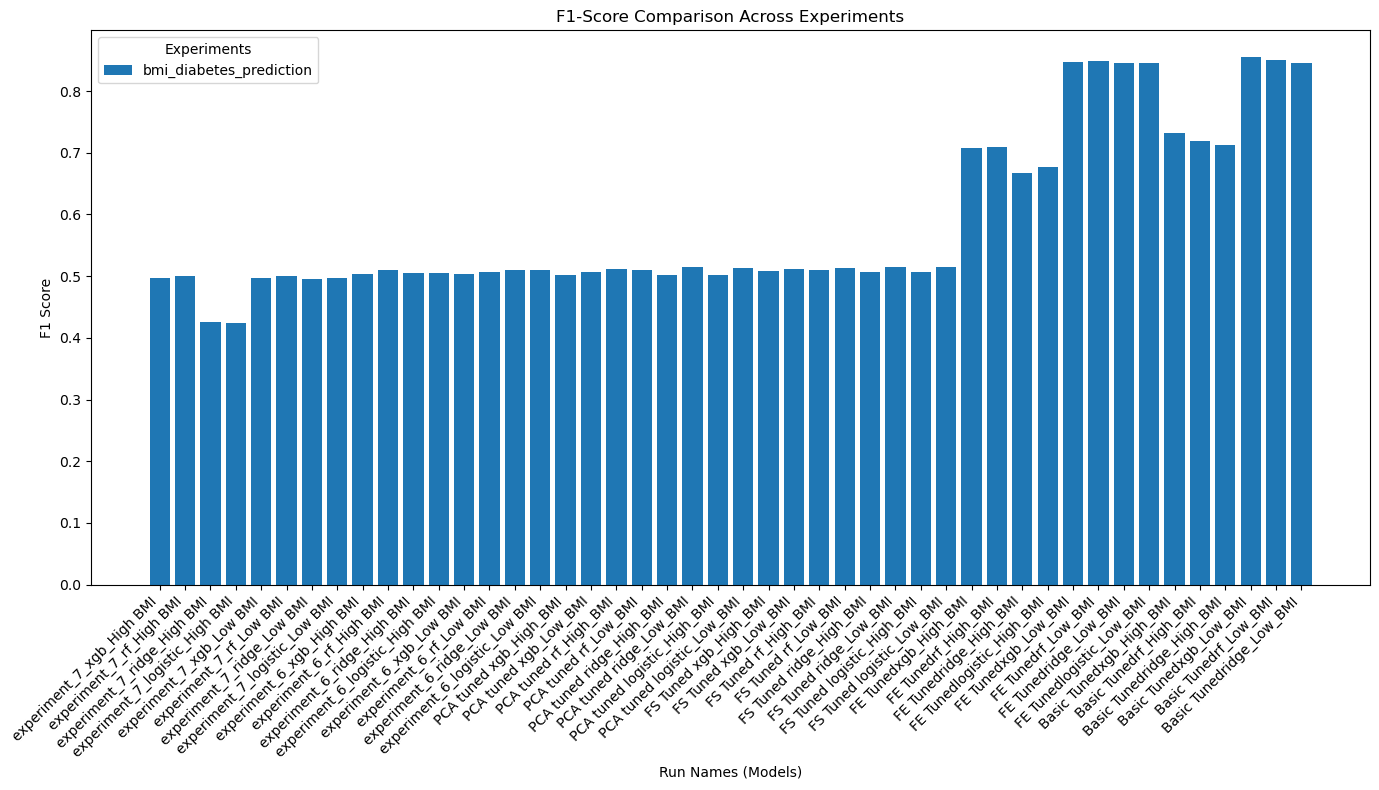


Best Model Based on F1-Score:
Experiment    bmi_diabetes_prediction
Run Name       Basic Tunedxgb_Low_BMI
Model                             XGB
F1 Score                     0.855723
Name: 43, dtype: object


In [455]:
import mlflow
import mlflow.tracking
import pandas as pd
import matplotlib.pyplot as plt
import re  # Import regex to extract model name

# --- Step 1: Set MLflow Tracking URI ---
mlflow.set_tracking_uri("https://dagshub.com/mpadmavathi026/Fall2024_diabetes_model.mlflow")  # Replace with your tracking URI
client = mlflow.tracking.MlflowClient()

# --- Step 2: Extract Experiment Data from MLflow ---
def get_f1_scores_from_mlflow():
    """
    Retrieves F1-scores and related information from MLflow experiments.
    Extracts the model name directly from the run name if not explicitly logged.
    """
    f1_scores = []
    experiments = client.search_experiments()
    
    for exp in experiments:
        experiment_id = exp.experiment_id
        runs = client.search_runs(experiment_ids=experiment_id)
        
        for run in runs:
            run_name = run.data.tags.get('mlflow.runName', 'Unknown')
            f1_score = run.data.metrics.get("F1 Score", None)
            # Extract model name from the run name using regex
            model_name_match = re.search(r"(logistic|ridge|rf|xgb)", run_name.lower())
            model_name = model_name_match.group(0).upper() if model_name_match else "Unknown Model"
            
            if f1_score is not None:
                f1_scores.append({
                    "Experiment": exp.name,
                    "Run Name": run_name,
                    "Model": model_name,
                    "F1 Score": f1_score
                })
    
    return pd.DataFrame(f1_scores)

# --- Step 3: Retrieve F1-Scores and Prepare Data ---
f1_score_df = get_f1_scores_from_mlflow()

if f1_score_df.empty:
    print("No F1-score data found in MLflow experiments.")
else:
    print("F1-Score Data Retrieved Successfully:")
    print(f1_score_df)

    # Save Data to CSV (optional)
    f1_score_df.to_csv("f1_scores_comparison.csv", index=False)

    # --- Step 4: Plot F1-Score Comparison ---
    plt.figure(figsize=(14, 8))
    for experiment in f1_score_df['Experiment'].unique():
        exp_data = f1_score_df[f1_score_df['Experiment'] == experiment]
        plt.bar(exp_data['Run Name'], exp_data['F1 Score'], label=experiment)

    plt.title("F1-Score Comparison Across Experiments")
    plt.xlabel("Run Names (Models)")
    plt.ylabel("F1 Score")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Experiments")
    plt.tight_layout()

    # Save the plot
    plt.savefig("f1_score_comparison.png")
    plt.show()

    # --- Step 5: Find and Print Best Model ---
    best_model = f1_score_df.loc[f1_score_df['F1 Score'].idxmax()]
    print("\nBest Model Based on F1-Score:")
    print(best_model)



In [580]:
import xgboost as xgb
import joblib
import os

# Define the tuned XGBoost model with hyperparameters
tuned_xgb_model = xgb.XGBClassifier(
    n_estimators=100,  # Use the correct hyperparameter names
    max_depth=7
)

# Ensure the model is trained (replace with your dataset variables)
# Example placeholders for training data
# Replace X_train_low and y_train_low with actual datasets
tuned_xgb_model.fit(X_train_low, y_train_low)

# Define the directory and path to save the model
save_dir = "/Users/padmavathimoorthy/Downloads/diabetes_app/saved_models"
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
model_path = os.path.join(save_dir, "tuned_xgb_low_bmi.pkl")

# Save the tuned model using joblib
joblib.dump(tuned_xgb_model, model_path)

print(f"Tuned XGBoost Model saved successfully to: {model_path}")


Tuned XGBoost Model saved successfully to: /Users/padmavathimoorthy/Downloads/diabetes_app/saved_models/tuned_xgb_low_bmi.pkl


In [574]:
import joblib
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Load X_test and y_test
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv").iloc[:, 0]  # Convert to pandas Series

# Load the saved XGB model
model_path = "saved_models/tuned_xgb_low_bmi.pkl"
final_model_loaded = joblib.load(model_path)
print("Loaded model type:", type(final_model_loaded))  # Should be xgboost.XGBClassifier

# Make predictions
y_pred = final_model_loaded.predict(X_test)

# Evaluate the model
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display evaluation results
print("\n=== Model Evaluation Results ===")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Loaded model type: <class 'xgboost.sklearn.XGBClassifier'>

=== Model Evaluation Results ===
F1 Score: 0.8543
Accuracy: 0.8950
Confusion Matrix:
[[23125     0   135]
 [  418     0    11]
 [ 2163     1   126]]


In [491]:
import sys
import subprocess

# Dynamically install fastapi and uvicorn
!{sys.executable} -m pip install fastapi uvicorn


In [493]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import numpy as np

# Load the tuned XGBoost model
model_path = "saved_models/tuned_xgb_low_bmi.pkl"
model = joblib.load(model_path)

# Initialize FastAPI
app = FastAPI(title="Diabetes Prediction API", description="Predict diabetes using a tuned XGBoost Model")

# Input data format
class InputData(BaseModel):
    features: list  # Example input: [5.0, 0.0, 3.0, 2.0, 25.0, 1.0, ...]

# Root endpoint
@app.get("/")
def root():
    return {"message": "Welcome to the Tuned XGBoost Diabetes Prediction API!"}

# Prediction endpoint
@app.post("/predict/")
def predict(data: InputData):
    try:
        input_features = np.array(data.features).reshape(1, -1)
        prediction = model.predict(input_features).tolist()
        return {"prediction": prediction}
    except Exception as e:
        return {"error": str(e)}


In [686]:
a_row = df.iloc[3]
a = a_row.to_dict()
a

{'Diabetes_012': 2.0,
 'HighBP': 0.0,
 'HighChol': 1.0,
 'CholCheck': 1.0,
 'BMI': 29.0,
 'Smoker': 0.0,
 'Stroke': 1.0,
 'HeartDiseaseorAttack': 1.0,
 'PhysActivity': 1.0,
 'Fruits': 1.0,
 'Veggies': 1.0,
 'HvyAlcoholConsump': 0.0,
 'AnyHealthcare': 1.0,
 'NoDocbcCost': 0.0,
 'GenHlth': 5.0,
 'MentHlth': 0.0,
 'PhysHlth': 30.0,
 'DiffWalk': 1.0,
 'Sex': 1.0,
 'Age': 12.0,
 'Education': 3.0,
 'Income': 4.0}

In [730]:
import json
data = json.dumps(a, indent=2)
print(data)

{
  "Diabetes_012": 2.0,
  "HighBP": 0.0,
  "HighChol": 1.0,
  "CholCheck": 1.0,
  "BMI": 29.0,
  "Smoker": 0.0,
  "Stroke": 1.0,
  "HeartDiseaseorAttack": 1.0,
  "PhysActivity": 1.0,
  "Fruits": 1.0,
  "Veggies": 1.0,
  "HvyAlcoholConsump": 0.0,
  "AnyHealthcare": 1.0,
  "NoDocbcCost": 0.0,
  "GenHlth": 5.0,
  "MentHlth": 0.0,
  "PhysHlth": 30.0,
  "DiffWalk": 1.0,
  "Sex": 1.0,
  "Age": 12.0,
  "Education": 3.0,
  "Income": 4.0
}


In [734]:
import requests
data = {
  "Diabetes_012": 2.0,
  "HighBP": 0.0,
  "HighChol": 1.0,
  "CholCheck": 1.0,
  "BMI": 29.0,
  "Smoker": 0.0,
  "Stroke": 1.0,
  "HeartDiseaseorAttack": 1.0,
  "PhysActivity": 1.0,
  "Fruits": 1.0,
  "Veggies": 1.0,
  "HvyAlcoholConsump": 0.0,
  "AnyHealthcare": 1.0,
  "NoDocbcCost": 0.0,
  "GenHlth": 5.0,
  "MentHlth": 0.0,
  "PhysHlth": 30.0,
  "DiffWalk": 1.0,
  "Sex": 1.0,
  "Age": 12.0,
  "Education": 3.0,
  "Income": 4.0
}
data = json.dumps(data, indent = 2)
print(data)
r = requests.post('http://127.0.0.1:8000/predict', data = data)
print(r.json())

{
  "Diabetes_012": 2.0,
  "HighBP": 0.0,
  "HighChol": 1.0,
  "CholCheck": 1.0,
  "BMI": 29.0,
  "Smoker": 0.0,
  "Stroke": 1.0,
  "HeartDiseaseorAttack": 1.0,
  "PhysActivity": 1.0,
  "Fruits": 1.0,
  "Veggies": 1.0,
  "HvyAlcoholConsump": 0.0,
  "AnyHealthcare": 1.0,
  "NoDocbcCost": 0.0,
  "GenHlth": 5.0,
  "MentHlth": 0.0,
  "PhysHlth": 30.0,
  "DiffWalk": 1.0,
  "Sex": 1.0,
  "Age": 12.0,
  "Education": 3.0,
  "Income": 4.0
}
{'prediction': 2}


In [742]:
import math

df_original = pd.read_csv("/Users/padmavathimoorthy/Downloads/diabetes_app/diabetes_012_health_indicators_BRFSS2021.csv")
slider_fields = [
    "BMI",
    "Income",
    "PhysHlth",
    "Age",
    "GenHlth"]

single_select_fields = [
    "HighBP",
    "HighChol",
    "CholCheck",
    "Smoker",
    "Stroke",
    "HeartDiseaseorAttack",
    "PhysActivity",
    "Fruits",
    "Veggies",
    "HvyAlcoholConsump",
    "AnyHealthcare",
    "NoDocbcCost",
    "DiffWalk",
    "Sex",
    "Education",
    "MentHlth"
] 
from collections import defaultdict
streamlit_field_data = defaultdict(dict)

for field in slider_fields:
    streamlit_field_data["slider_fields"][field] = [math.floor(df_original[field].min()), math.ceil(df_original[field].max())]


for field in single_select_fields:
    streamlit_field_data["single_select_fields"][field] = df_original[field].unique().tolist()


import json
json.dump(streamlit_field_data, open("streamlit_options.json", "w"), indent = 2)

In [706]:
sorted(df_original["Smoker"].unique())

[0.0, 1.0]